In [1]:
import COSMO_TL as ctl
sf = ctl.sigma_functions
gl = ctl.GammaLoaders
md = ctl.model
pd = sf.pd


c:\Users\efons\anaconda3\envs\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# import the csv file
df = pd.read_csv('../data/vaspsol_data_3_2_2023.csv')
df

,Unnamed: 0,Solvent,FileHandle,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,SoluteName,...,sigma_solvent_41,sigma_solvent_42,sigma_solvent_43,sigma_solvent_44,sigma_solvent_45,sigma_solvent_46,sigma_solvent_47,sigma_solvent_48,sigma_solvent_49,sigma_solvent_50
0,0,water,0157flu,0.0010,0.200000,0.000670,0.073867,-76.193434,2240,fluorobenzene,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,water,0157flu,0.0020,0.866667,0.000010,-0.200151,-76.467452,2240,fluorobenzene,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,water,0157flu,0.0010,1.200000,0.001000,-0.042744,-76.310045,2240,fluorobenzene,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,water,0157flu,0.0010,0.200000,0.001000,0.152467,-76.114834,2240,fluorobenzene,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,water,0157flu,0.0030,0.533333,0.000340,-0.097007,-76.364308,2240,fluorobenzene,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6534,6534,mcresol,0036tol,0.0025,0.600000,0.000525,0.006012,-92.653357,1438,toluene,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6535,6535,bromoethane,0036tol,0.0025,0.600000,0.000525,0.015738,-92.643631,181,toluene,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6536,6536,butylbenzene,0078pen,0.0025,0.600000,0.000525,0.020910,-89.013866,261,2-pentanone,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6537,6537,secbutanol,0069met,0.0025,0.600000,0.000525,-0.114669,-22.252249,1934,formaldehyde,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# group by NC_K, SIGMA_K, TAU, and FileHandle
vs_grouped = df.groupby(['NC_K', 'SIGMA_K', 'TAU', 'FileHandle'])
# print the stats
vs_grouped.describe()

KeyboardInterrupt: 

In [6]:
# load the data into a dask dataframe
import dask.dataframe as dd
vasp_df = dd.from_pandas(df, npartitions=4)
vasp_df_grouped = vasp_df.groupby(['NC_K', 'SIGMA_K', 'TAU', 'FileHandle'])
# get all groups with a std greater than 0 or is not NaN
stds = vasp_df_grouped['Solvation_Energy'].std()
found_groups = stds[(stds > 0) ].compute()
found_groups

NC_K      SIGMA_K   TAU       FileHandle
0.001000  0.200000  0.000525  0008noc       0.016266
          0.300000  0.000525  0008noc       0.021793
          0.400000  0.000525  0008noc       0.017598
          0.500000  0.000525  0008noc       0.019240
          0.600000  0.000525  0008noc       0.016060
                                              ...   
0.002500  0.630000  0.000525  0086eth       0.000026
          1.000000  0.000525  0086eth       0.000448
0.002625  0.600000  0.000525  0086eth       0.000199
0.002681  0.653333  0.000540  0086eth       0.000331
0.002741  0.661111  0.000544  0086eth       0.000216
Name: Solvation_Energy, Length: 365, dtype: float64

In [10]:
# get all the columns with "sigma" in the name
import numpy as np
sig_cols = [col for col in df.columns if 'sigma_solute' in col]
try:
    sig_cols.remove('sigma_solute')
except:
    pass
sig_array = df[sig_cols].to_numpy()

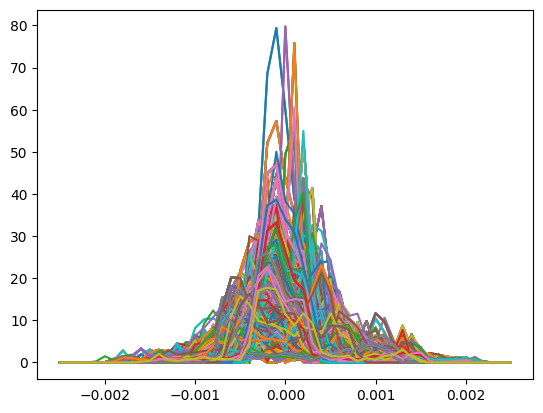

In [11]:
# plot all the sigma_profiles. 
import matplotlib.pyplot as plt
x = np.linspace(-2.5e-3, 2.5e-3, 51)
for i in range(0, len(sig_array)):
    plt.plot(x, sig_array[i])

In [12]:
# define default vaspsol parameters
NC_K = 2.5e-3
SIGMA_K = 0.6
TAU = 5.25e-4
# get all entries with the default parameters
default_df = df[(df['NC_K'] == NC_K) & (df['SIGMA_K'] == SIGMA_K) & (df['TAU'] == TAU)]
# drop the Unnamed column
default_df = default_df.drop(columns=['Unnamed: 0'])
default_df = default_df[default_df['Charge'] == 0]
# lets remove the duplicate entries using the No. column
default_df = default_df.drop_duplicates(subset=['No.'])
default_df = default_df.reset_index(drop=True)
default_df

,Solvent,FileHandle,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,SoluteName,Formula,...,sigma_solvent_41,sigma_solvent_42,sigma_solvent_43,sigma_solvent_44,sigma_solvent_45,sigma_solvent_46,sigma_solvent_47,sigma_solvent_48,sigma_solvent_49,sigma_solvent_50
0,water,0157flu,0.0025,0.6,0.000525,-0.076483,-76.381271,2240,fluorobenzene,H5C6F1,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,water,0169chl,0.0025,0.6,0.000525,-0.049470,-30.672340,2249,chloroethene,H3C2CL1,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,water,0153flu,0.0025,0.6,0.000525,-0.078812,-24.018117,2238,fluoromethane,H3C1F1,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,water,0151phy,0.0025,0.6,0.000525,-0.439443,-98.590647,2237,p-hydroxybenzaldehyde,H6C7O2,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,water,0198chl,0.0025,0.6,0.000525,-0.109359,-22.643265,2268,chlorofluoromethane,H2C1F1CL1,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,mcresol,0036tol,0.0025,0.6,0.000525,0.006012,-92.653357,1438,toluene,H8C7,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1083,bromoethane,0036tol,0.0025,0.6,0.000525,0.015738,-92.643631,181,toluene,H8C7,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1084,butylbenzene,0078pen,0.0025,0.6,0.000525,0.020910,-89.013866,261,2-pentanone,H10C5O1,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1085,secbutanol,0069met,0.0025,0.6,0.000525,-0.114669,-22.252249,1934,formaldehyde,H2C1O1,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# for every duplicate of the FileHandle, get the lowest error
default_df = default_df.sort_values(by=['FileHandle', 'error'])
default_df = default_df.drop_duplicates(subset=['FileHandle'], keep='first')
default_df 

,Solvent,FileHandle,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,SoluteName,Formula,...,sigma_solvent_41,sigma_solvent_42,sigma_solvent_43,sigma_solvent_44,sigma_solvent_45,sigma_solvent_46,sigma_solvent_47,sigma_solvent_48,sigma_solvent_49,sigma_solvent_50
510,octanol,0001met,0.0025,0.6,0.000525,0.028653,-24.016803,1578,methane,H4C1,...,0.193256,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,water,0002eth,0.0025,0.6,0.000525,0.031741,-40.483197,2094,ethane,H6C2,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157,water,0003pro,0.0025,0.6,0.000525,0.034717,-56.999758,2095,n-propane,H8C3,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195,water,0004nbu,0.0025,0.6,0.000525,0.044792,-73.535395,2096,n-butane,H10C4,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153,water,0005npe,0.0025,0.6,0.000525,0.047490,-90.061009,2097,n-pentane,H12C5,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,water,test3001,0.0025,0.6,0.000525,-0.542500,-127.867000,2464,paracetamol,H9C8N1O2,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,water,test3007,0.0025,0.6,0.000525,-0.381230,-121.893260,2469,2-methoxybenzoicacid,H8C8O3,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
227,water,test3014,0.0025,0.6,0.000525,-0.356480,-122.032090,2470,4-methoxybenzoicacid,H8C8O3,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
182,water,test3015,0.0025,0.6,0.000525,-0.371450,-122.046800,2471,3-methoxybenzoicacid,H8C8O3,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# save this as "VASPsol_water.csv"
default_df.to_csv('VASPsol_water.csv')


In [15]:
# get the sigma profiles for the default parameters
sig_array = default_df[sig_cols].to_numpy()
# append the error to the end of the array
M1 = np.append(sig_array, default_df['error'].to_numpy().reshape(-1, 1), axis=1)


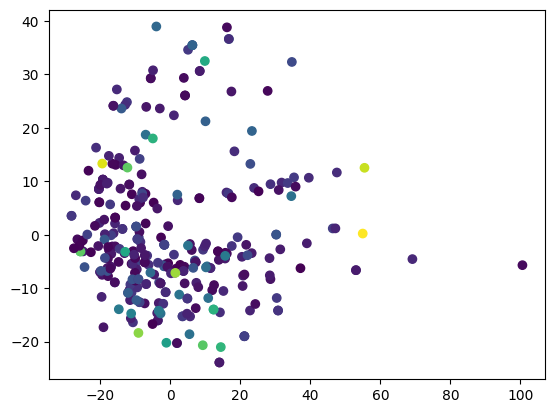

In [16]:
# pca in 2d and plot. color by the error column
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
M1_prime = pca.fit_transform(M1)
plt.scatter(M1_prime[:, 0], M1_prime[:, 1], c=default_df['error'], cmap='viridis')


(array([86., 78., 45., 44., 16., 12.,  8.,  9.,  4.,  1.,  1.,  3.,  3.,
         1.,  1.,  2.,  1.,  1.,  1.,  2.]),
 array([7.40060000e-04, 4.92062687e-01, 9.83385314e-01, 1.47470794e+00,
        1.96603057e+00, 2.45735319e+00, 2.94867582e+00, 3.43999845e+00,
        3.93132108e+00, 4.42264370e+00, 4.91396633e+00, 5.40528896e+00,
        5.89661158e+00, 6.38793421e+00, 6.87925684e+00, 7.37057946e+00,
        7.86190209e+00, 8.35322472e+00, 8.84454735e+00, 9.33586997e+00,
        9.82719260e+00]),
 <BarContainer object of 20 artists>)

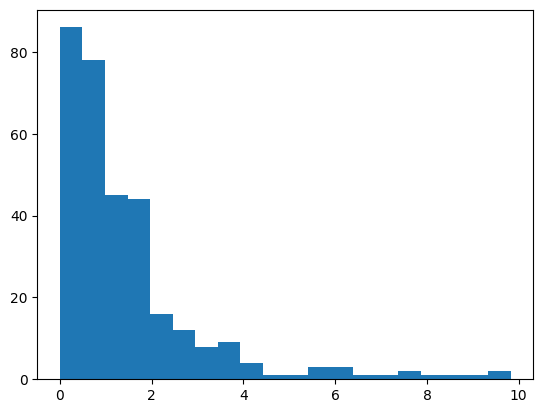

In [17]:
# plot a histogram of the error
plt.hist(default_df['error'], bins=20)

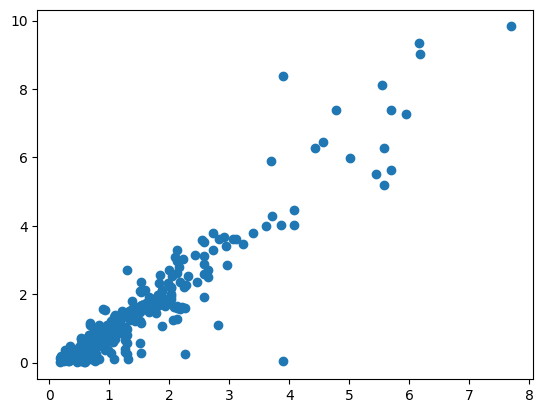

In [18]:
# lets use shapley values to see which features are most important
# first train random forest model and create features. use the sigma profiles as features

from sklearn.ensemble import RandomForestRegressor

X = default_df[sig_cols].to_numpy()

Y = default_df['error'].to_numpy()

model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X, Y)

# parity plot of the training error
plt.scatter(model.predict(X), Y)


([<matplotlib.axis.XTick at 0x220162c08b0>,
 [Text(0, 0, '-0.0025'),
  Text(1, 0, '-0.0024'),
  Text(2, 0, '-0.0023'),
  Text(3, 0, '-0.0022'),
  Text(4, 0, '-0.0021'),
  Text(5, 0, '-0.002'),
  Text(6, 0, '-0.0019'),
  Text(7, 0, '-0.0018'),
  Text(8, 0, '-0.0017'),
  Text(9, 0, '-0.0016'),
  Text(10, 0, '-0.0015'),
  Text(11, 0, '-0.0014'),
  Text(12, 0, '-0.0013'),
  Text(13, 0, '-0.0012'),
  Text(14, 0, '-0.0011'),
  Text(15, 0, '-0.001'),
  Text(16, 0, '-0.0009'),
  Text(17, 0, '-0.0008'),
  Text(18, 0, '-0.0007'),
  Text(19, 0, '-0.0006'),
  Text(20, 0, '-0.0005'),
  Text(21, 0, '-0.0004'),
  Text(22, 0, '-0.0003'),
  Text(23, 0, '-0.0002'),
  Text(24, 0, '-0.0001'),
  Text(25, 0, '0.0'),
  Text(26, 0, '0.0001'),
  Text(27, 0, '0.0002'),
  Text(28, 0, '0.0003'),
  Text(29, 0, '0.0004'),
  Text(30, 0, '0.0005'),
  Text(31, 0, '0.0006'),
  Text(32, 0, '0.0007'),
  Text(33, 0, '0.0008'),
  Text(34, 0, '0.0009'),
  Text(35, 0, '0.001'),
  Text(36, 0, '0.0011'),
  Text(37, 0, '0.0012'

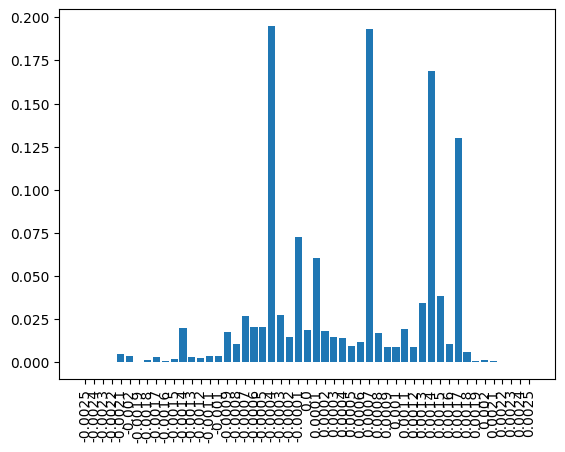

In [19]:
# lets try permutation importance

from sklearn.inspection import permutation_importance

pi = permutation_importance(model, X, Y, n_repeats=10, random_state=0)

# plot the permutation importance
plt.bar(sig_cols, pi.importances_mean)
# label the bars with the feature names
x_names = np.linspace(-2.5e-3, 2.5e-3, 51).round(4).astype(str)
plt.xticks(np.arange(len(sig_cols)), x_names, rotation=90)





In [22]:
# Lets find the water sigma profile
water = default_df[default_df['SoluteName'] == 'water']
water_sigma = water[sig_cols].to_numpy()
area_water = water['area_solute'].to_numpy()
volume_water = water['volume_solute'].to_numpy()[0]
water_sigma, area_water, volume_water

(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.63394573,
         2.377619  , 2.96856453, 1.44455553, 1.82204175, 2.00355418,
         2.54564325, 1.95869731, 0.99672505, 0.40136367, 0.48717331,
         1.1653547 , 0.80350149, 1.34866749, 0.06087301, 0.01852758,
         0.83669546, 1.07831424, 0.49951627, 1.15689095, 0.73389194,
         0.70673299, 1.3902221 , 0.91741766, 1.44266098, 0.43311828,
         0.95035368, 1.22948396, 2.30884787, 2.32448781, 2.72211829,
         1.3681807 , 2.05339247, 0.08014676, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]]),
 array([43.26923]),
 25.73454)

In [23]:
import COSMO_TL as ctl
sf = ctl.sigma_functions
area = default_df['area_solute'].to_numpy()
volume = default_df['volume_solute'].to_numpy().reshape(-1)


In [24]:
cosmos = [sf.COSMO(X[i, :], water_sigma, volume[i], volume_water, x1=np.array([2.5e-9])) for i in range(0, len(volume))]

In [25]:
gammas = np.array([cosmo.get_gamma()[0] for cosmo in cosmos]).reshape(-1,1)

(array([ 2.,  3.,  4., 14.,  4., 23., 29., 38., 43., 40., 36., 25., 25.,
        10., 10.,  6.,  1.,  5.,  0.,  1.]),
 array([-3.54157253, -2.5841232 , -1.62667388, -0.66922456,  0.28822477,
         1.24567409,  2.20312341,  3.16057274,  4.11802206,  5.07547138,
         6.03292071,  6.99037003,  7.94781935,  8.90526868,  9.862718  ,
        10.82016732, 11.77761665, 12.73506597, 13.69251529, 14.64996462,
        15.60741394]),
 <BarContainer object of 20 artists>)

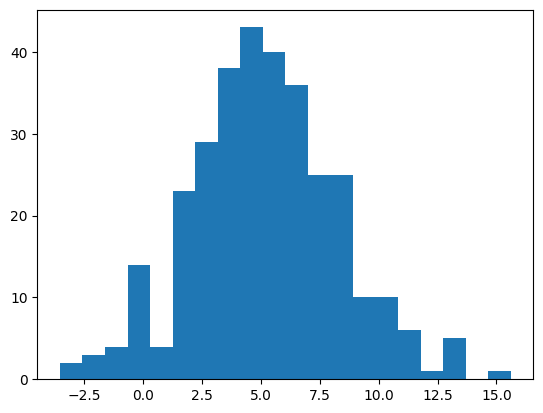

In [26]:
# plot a hist of the gammas
plt.hist(gammas, bins=20)

In [27]:
# Append the gammas to the dataframe
X2 = np.append(X, gammas, axis=1)
# create a index column vector for the data
index = np.arange(0, len(X2)).reshape(-1)
# shuffle the data
np.random.shuffle(index)
# split the data into training and testing
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split(index, test_size=0.2, random_state=0)

In [28]:
# rerun the permutation importance with X2
model2 = RandomForestRegressor(n_estimators=100, random_state=0)
model2.fit(X2[index_train, :], Y[index_train].reshape(-1,1))
pi2 = permutation_importance(model2, X2[index_test, :], Y[index_test], n_repeats=10, random_state=0)


C:\Users\efons\AppData\Local\Temp\ipykernel_25080\1598732894.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model2.fit(X2[index_train, :], Y[index_train].reshape(-1,1))


Text(0, 0.5, 'Mean Permutation Importance')

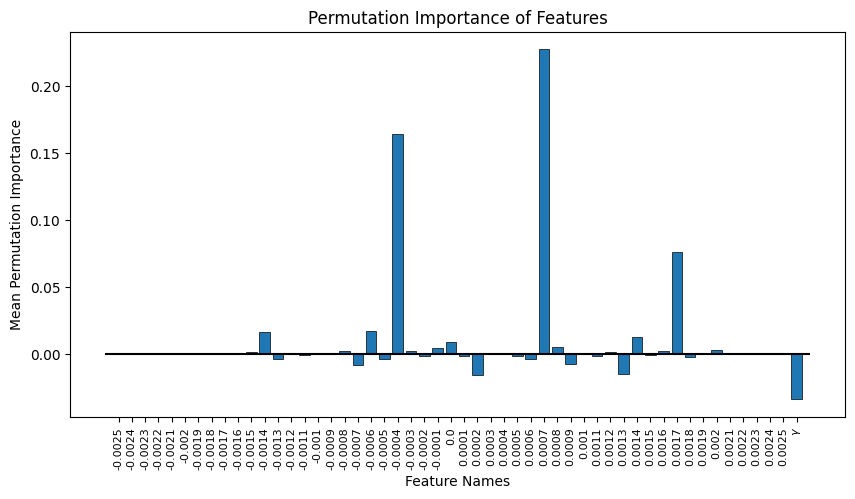

In [29]:
# plot the permutation importance with a bar chart. Label the bars with the feature names. format first 51 with \sigma_ and the x_sigma value
x_sigma = np.linspace(-2.5e-3, 2.5e-3, 51).round(4).astype(str)
feature_names = [x_sigma[i] for i in range(0, len(x_sigma))]
feature_names.append('$\gamma$')
# make the figure wide 
fig, ax = plt.subplots(figsize=(10, 5))
# add a thin outline around the bars
plt.bar(feature_names, pi2.importances_mean, edgecolor='black', linewidth=0.5)
# rotate the x labels 90 degrees and the font size to 8
plt.xticks(rotation=90, fontsize=8)
# add a black horizontal line at y=0
plt.hlines(0, -1, len(feature_names), colors='black')
# add a title
plt.title('Permutation Importance of Features')
plt.xlabel('Feature Names')
plt.ylabel('Mean Permutation Importance')

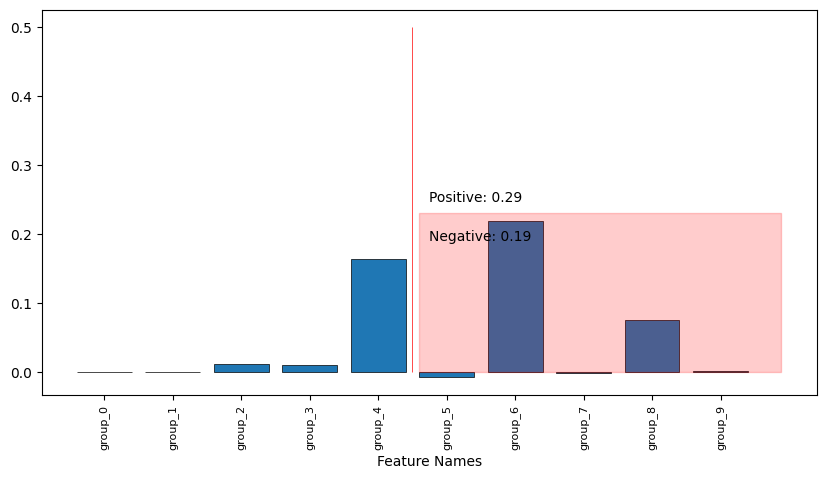

In [30]:
# lets remake the plot from above but bin every n bars together
N = 5
pi_new = np.zeros((len(pi2.importances_mean)//N, 1))
pi_new = np.array([np.sum(pi2.importances_mean[i*N:(i+1)*N]) for i in range(0, len(pi_new))])

# remake the bar plot with pi_new
feature_names = ['group_{}'.format(i) for i in range(0, len(pi_new))]
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(feature_names, pi_new, edgecolor='black', linewidth=0.5)
plt.xlabel('Feature Names')
plt.xticks(rotation=90, fontsize=8)
# make a red background from group_5 to group_9
# get the x coordinates of the bars
box_coords_x = [i.get_x() for i in ax.patches]
box_coords_x = np.array(box_coords_x)
box_coords_x = box_coords_x[5:10]
box_coords_x = np.array([box_coords_x[0], box_coords_x[-1]])
box_coords_x[-1] = ax.get_xlim()[-1]
# get the y coordinates of the whole plot
y_coords = ax.get_ylim()
y_coords = [y_coords[-1], y_coords[-1]]
# make a red background
plt.fill_between(box_coords_x, y_coords, color='red', alpha=0.2)
# sum groups 5 through 9 and add a text label
pi_positive = np.sum(pi_new[5:10])
# sum groups 0 through 4 and add a text label
pi_negative = np.sum(pi_new[0:5])

plt.text(0.5, 0.5, 'Positive: {:.2f}'.format(pi_positive), transform=ax.transAxes)
plt.text(0.5, 0.4, 'Negative: {:.2f}'.format(pi_negative), transform=ax.transAxes)

# add a red verticle line at group 4
plt.vlines(4.5, 0, 0.5, colors='red', linewidth=0.5)

In [31]:
# list of testing molecules
names = ['n-octane','ethanol','nitromethane','phenol','toluene','1,4-dioxane','acetone','acetic acid']

In [32]:
import pandas as pd
vasp_df = pd.read_csv('VASPsol_water.csv')
test_csv = vasp_df[vasp_df['SoluteName'].isin(names)]

In [35]:
import COSMO_TL as ctl
sig_cols = ['sigma_solute_{}'.format(i) for i in range(0, 51)]
test_sigmas = test_csv[sig_cols].to_numpy()

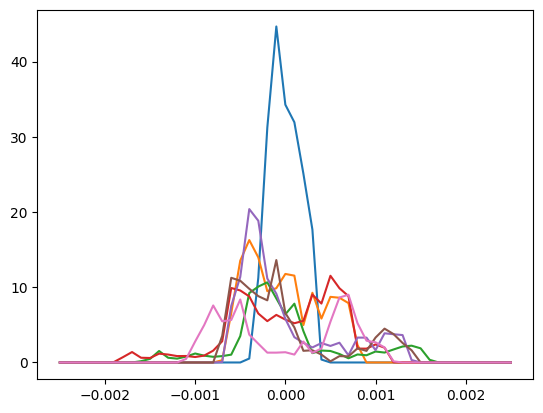

In [36]:
# plot all the sigma profiles together
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-2.5e-3, 2.5e-3, 51)
for i in range(0, len(test_sigmas)):
    plt.plot(x, test_sigmas[i, :], label=names[i])

(array([-0.003, -0.002, -0.001,  0.   ,  0.001,  0.002,  0.003]),
 [Text(-0.003, 0, '−0.003'),
  Text(-0.002, 0, '−0.002'),
  Text(-0.001, 0, '−0.001'),
  Text(0.0, 0, '0.000'),
  Text(0.001, 0, '0.001'),
  Text(0.002, 0, '0.002'),
  Text(0.003, 0, '0.003')])

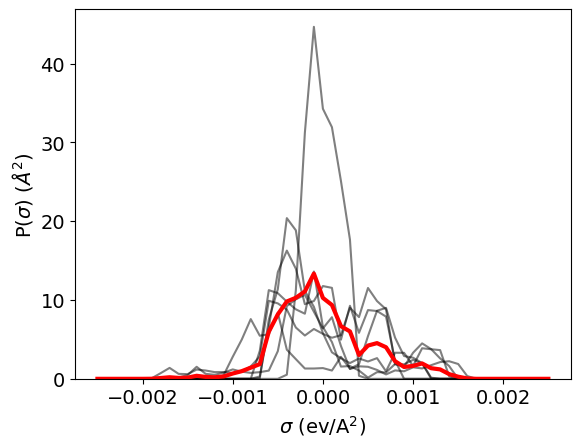

In [37]:
# get the average profile by averaging column wise
avg_sig = np.mean(test_sigmas, axis=0)
# plot

#plot the other sigma profiles as transparent lines behind the avg line
for i in range(0, len(test_sigmas)):
    plt.plot(x, test_sigmas[i, :], alpha=0.5, color='black')

plt.plot(x, avg_sig, label='Average', linewidth=3, color='red') 
plt.xlabel('$\sigma$ (ev/A$^2$)', fontsize=14)
plt.ylabel('P($\sigma$) ($\AA^{2}$)', fontsize=14)
# change the lower ylim to 0
plt.ylim(0, plt.ylim()[-1])
# make the tick labels larger
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

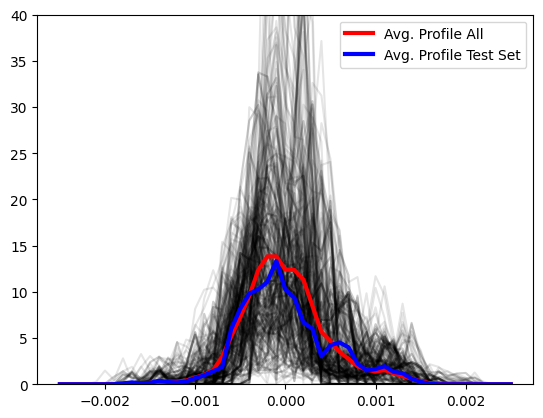

In [38]:
# get the average profile from vasp_df
sig_all = vasp_df[sig_cols].to_numpy()
sig_all_avg = np.mean(sig_all, axis=0)
# make the same plot
for i in range(0, len(sig_all)):
    plt.plot(x, sig_all[i, :], alpha=0.1, color='black')
plt.plot(x, sig_all_avg, label='Avg. Profile All', linewidth=3, color='red')
plt.plot(x, avg_sig, label='Avg. Profile Test Set', linewidth=3, color='blue')
plt.ylim(0, 40)
plt.legend()

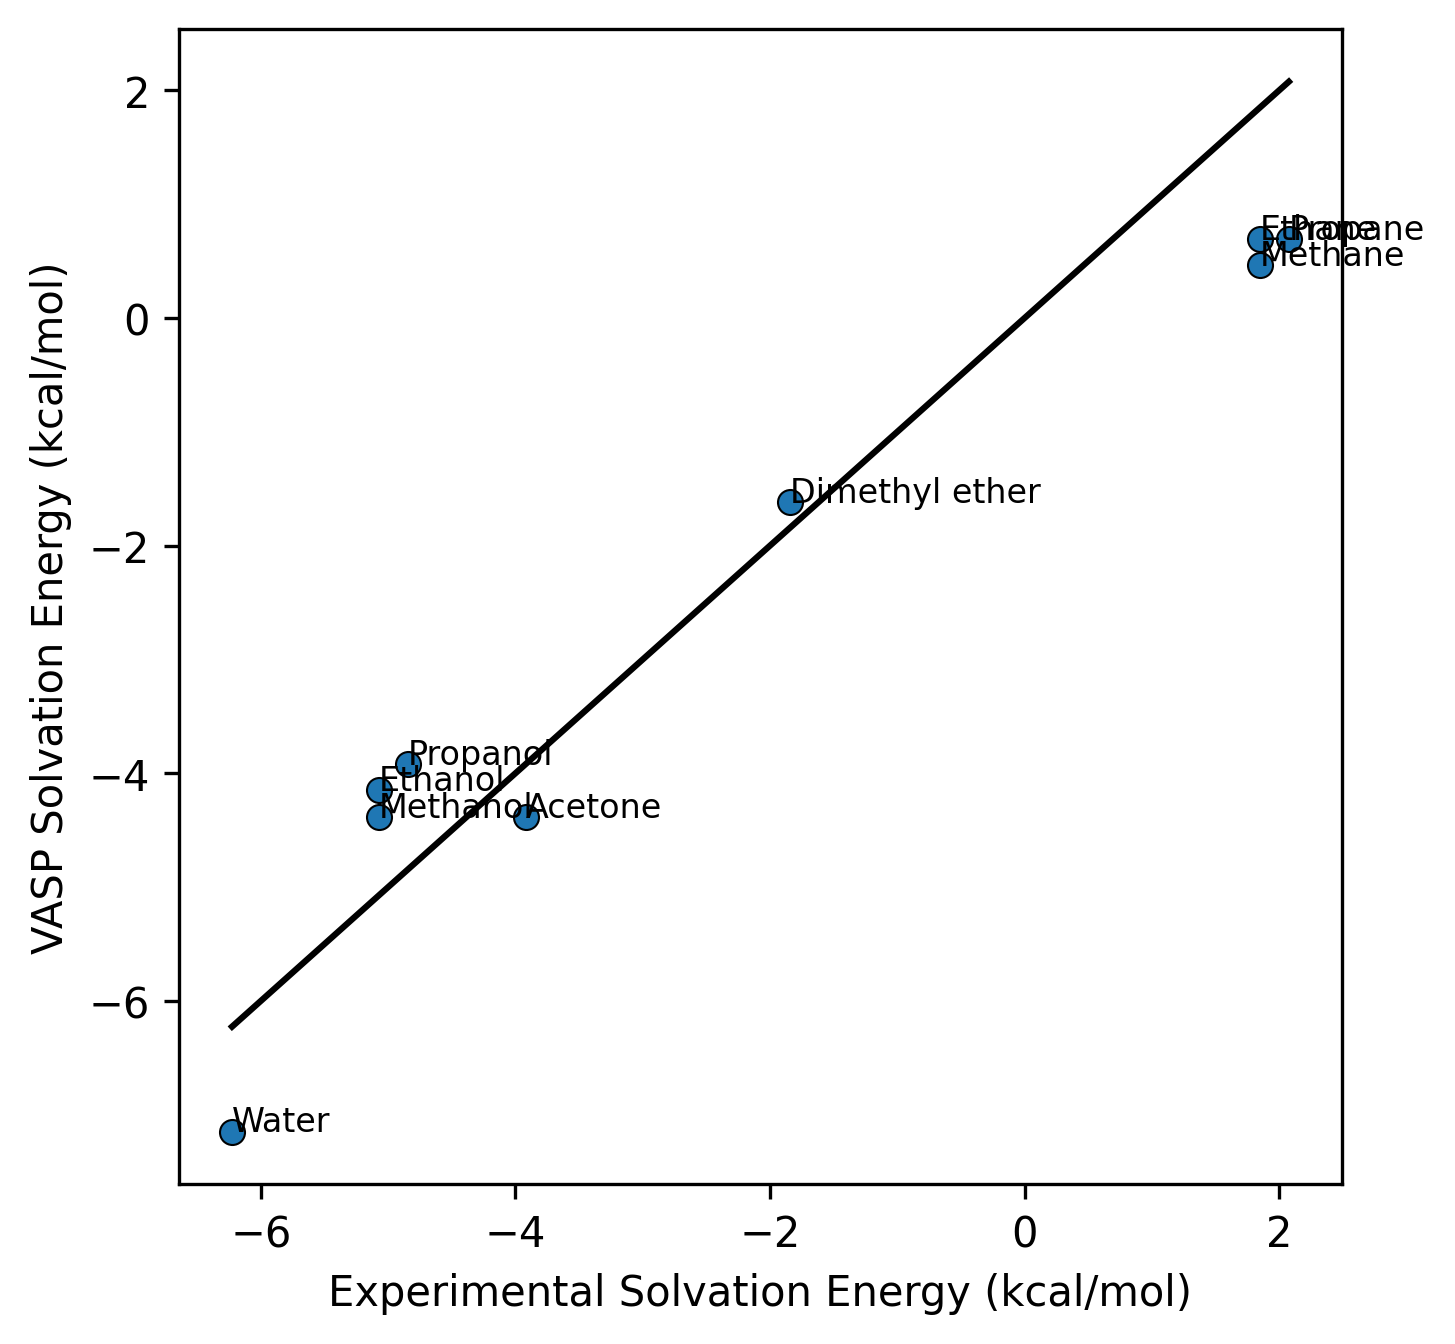

In [189]:
original = pd.read_excel('VASP_Original_Benchmark.xlsx')
# make a parity plot
x_parity = original['Expt']*23.06
y_parity = original['PAW']*23.06
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
plt.scatter(x_parity, y_parity, label='PAW', edgecolors='black', linewidth=0.5)
# add a parity line
plt.plot([x_parity.min(), x_parity.max()], [x_parity.min(), x_parity.max()], color='black', label='Parity')
plt.xlabel('Experimental Solvation Energy (kcal/mol)')
plt.ylabel('VASP Solvation Energy (kcal/mol)')
# make a box in the upper right corner with the stats, R2, RMSE, MAE
r2 = ctl.model.r2_score(x_parity, y_parity)
mae = ctl.model.mean_absolute_error(x_parity, y_parity)
rmse = np.sum((x_parity - y_parity)**2/ len(x_parity))**0.5
# label each point with the name of the molecules
molecules = original['Molecule']
# get the points of each molecule
coords = zip(x_parity, y_parity)
text_coords = np.array(list(coords))
for i in range(0, len(molecules)):
    plt.text(text_coords[i, 0], text_coords[i, 1], molecules[i], fontsize=8)

In [190]:
#print the stats
print('R2: {:.2f}'.format(r2))
print('MAE: {:.2f}'.format(mae))
print('RMSE: {:.2f}'.format(rmse))

R2: 0.91
MAE: 0.90
RMSE: 0.97


In [11]:
sol_data = pd.read_csv('ML_TRUHLER_VASPSOL_OPT2.csv')
sol_data

,Unnamed: 0,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,FileHandle,SoluteName,Formula,...,sigma_41,sigma_42,sigma_43,sigma_44,sigma_45,sigma_46,sigma_47,sigma_48,sigma_49,sigma_50
0,0,0.002472,0.448381,0.000635,0.125520,-139.568960,2100,0008noc,n-octane,H18C8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30,0.002442,0.465850,0.000624,0.121470,-139.573010,2100,0008noc,n-octane,H18C8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,60,0.002517,0.419506,0.000655,0.132640,-139.561840,2100,0008noc,n-octane,H18C8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,90,0.002471,0.449172,0.000635,0.125330,-139.569150,2100,0008noc,n-octane,H18C8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,120,0.002491,0.450552,0.000632,0.124000,-139.570480,2100,0008noc,n-octane,H18C8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5972,104054,0.002667,0.555556,0.000525,-0.267208,-32.104329,3022,i050,methanol,H5C1O1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5973,104056,0.003000,0.555556,0.000525,-0.295242,-32.132363,3022,i050,methanol,H5C1O1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5974,104058,0.002667,0.466667,0.000525,-0.228526,-32.065647,3022,i050,methanol,H5C1O1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5975,104060,0.001333,0.377778,0.000525,-0.108113,-31.945234,3022,i050,methanol,H5C1O1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(-9.247645299219432, 3.701174105810929)

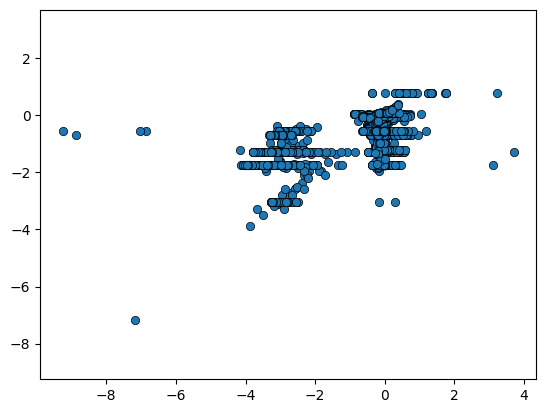

In [12]:
# get a gaussian kernel model to estimate the error using sig_cols\

sol_data = sol_data[sol_data['error_ev'].abs() < 10]

X = sol_data[sig_cols].to_numpy()
Y = sol_data['error_ev'].to_numpy()
# make a gaussian kernel model
from sklearn.gaussian_process import GaussianProcessRegressor
model = GaussianProcessRegressor()
model.fit(X, Y)
# get the error for each molecule
pred = model.predict(X)

# parity plot
plt.scatter(Y, pred, edgecolors='black', linewidth=0.5)
# use the limits of Y to set the limits of the parity line
plt.ylim(Y.min(), Y.max())

In [28]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2 = r2_score(Y, pred)
mae = mean_absolute_error(Y, pred)
mse = mean_squared_error(Y, pred)
print('R2: {:.2f}'.format(r2))
print('MAE: {:.2f}'.format(mae))
print('MSE: {:.2f}'.format(mse))

R2: 0.32
MAE: 0.71
MSE: 1.15


In [39]:
# get the NC_K, SIGMA_K, and TAU for each molecule
sol_data = pd.read_csv('../data/vaspsol_data_3_2_2023.csv')
# remove the molecules with errors greater than 10
sol_data = sol_data[sol_data['error'].abs() < 1]
nc_k = sol_data['NC_K'].to_numpy()
sigma_k = sol_data['SIGMA_K'].to_numpy()
tau = sol_data['TAU'].to_numpy()
sigmas = sol_data[sig_cols].to_numpy()
sol_data

,Unnamed: 0,Solvent,FileHandle,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,SoluteName,...,sigma_solvent_41,sigma_solvent_42,sigma_solvent_43,sigma_solvent_44,sigma_solvent_45,sigma_solvent_46,sigma_solvent_47,sigma_solvent_48,sigma_solvent_49,sigma_solvent_50
2,2,water,0157flu,0.0010,1.200000,0.001000,-0.042744,-76.310045,2240,fluorobenzene,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,water,0157flu,0.0010,0.200000,0.000340,0.005553,-76.261748,2240,fluorobenzene,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,13,water,0157flu,0.0010,0.866667,0.000670,0.004771,-76.262530,2240,fluorobenzene,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,14,water,0157flu,0.0010,0.866667,0.000340,-0.059342,-76.326643,2240,fluorobenzene,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,20,water,0157flu,0.0010,0.533333,0.000340,-0.017243,-76.284544,2240,fluorobenzene,...,2.053392,0.080147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6491,6491,nitroethane,0130nit,0.0025,0.600000,0.000525,-0.197656,-56.099187,1495,nitroethane,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6492,6492,nitroethane,0506nit,0.0025,0.600000,0.000525,-0.221550,-39.490821,1496,nitromethane,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6497,6497,methylformamide,0076but,0.0025,0.600000,0.000525,-0.216540,-72.730864,1472,2-butanone,...,0.267152,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6505,6505,tetrahydrothiophenedioxide,0076but,0.0025,0.600000,0.000525,-0.156560,-72.670884,1983,2-butanone,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
sol_data['error']

2       0.205677
7       0.908052
13      0.890019
14      0.588427
20      0.382376
          ...   
6491    0.972053
6492    0.241057
6497    0.653412
6505    0.479726
6537    0.215733
Name: error, Length: 3013, dtype: float64

In [41]:
# group the dataframe using NC_K, SIGMA_K, and TAU
sol_data = sol_data[sol_data['TAU'] == 0.000525]
grouped_parameters = sol_data.groupby(['NC_K', 'SIGMA_K'])
# get the average error for each group
avg_error = grouped_parameters['error'].mean()

x = grouped_parameters['NC_K']
y = grouped_parameters['SIGMA_K']
z = avg_error
z

NC_K    SIGMA_K 
0.0004  1.500000    0.290092
0.0007  0.800000    0.473203
0.0010  0.100000    0.701192
        0.200000    0.515155
        0.288889    0.454161
                      ...   
0.0040  0.400000    0.569854
        0.466667    0.246115
        0.555556    0.668895
        0.600000    0.812936
        0.644444    0.309511
Name: error, Length: 133, dtype: float64

In [42]:
combos = np.array(list(x.indices.keys())).reshape(-1, 2)
combos

array([[4.00000000e-04, 1.50000000e+00],
       [7.00000000e-04, 8.00000000e-01],
       [1.00000000e-03, 1.00000000e-01],
       [1.00000000e-03, 2.00000000e-01],
       [1.00000000e-03, 2.88888889e-01],
       [1.00000000e-03, 3.00000000e-01],
       [1.00000000e-03, 3.77777778e-01],
       [1.00000000e-03, 4.00000000e-01],
       [1.00000000e-03, 4.66666667e-01],
       [1.00000000e-03, 5.00000000e-01],
       [1.00000000e-03, 5.55555556e-01],
       [1.00000000e-03, 6.00000000e-01],
       [1.00000000e-03, 6.44444444e-01],
       [1.00000000e-03, 7.00000000e-01],
       [1.00000000e-03, 7.33333333e-01],
       [1.00000000e-03, 8.00000000e-01],
       [1.00000000e-03, 8.00000000e-01],
       [1.00000000e-03, 8.22222222e-01],
       [1.00000000e-03, 9.00000000e-01],
       [1.00000000e-03, 9.11111111e-01],
       [1.00000000e-03, 1.00000000e+00],
       [1.33333333e-03, 2.00000000e-01],
       [1.33333333e-03, 2.88888889e-01],
       [1.33333333e-03, 3.77777778e-01],
       [1.333333

In [43]:
# make a 3D plot of the average error as a function of NC_K, SIGMA_K, and TAU
x = combos[:, 0]
y = combos[:, 1]
z = avg_error.to_numpy()
z

array([0.29009237, 0.47320322, 0.7011919 , 0.5151549 , 0.4541612 ,
       0.3553546 , 0.4061964 , 0.36015693, 0.3443956 , 0.3137313 ,
       0.51808951, 0.35740142, 0.26997544, 0.3417492 , 0.02626485,
       0.29176616, 0.39375777, 0.39073968, 0.51482   , 0.61985071,
       0.35361539, 0.3243334 , 0.2118006 , 0.50100205, 0.27780431,
       0.08095812, 0.29674712, 0.70452345, 0.39858459, 0.57985865,
       0.58487703, 0.2221776 , 0.1555342 , 0.0722876 , 0.038631  ,
       0.1982062 , 0.4334182 , 0.7956908 , 0.1091836 , 0.38035213,
       0.2259594 , 0.11076822, 0.42425739, 0.60618051, 0.32332828,
       0.48673338, 0.54717504, 0.13725274, 0.35539153, 0.0591544 ,
       0.16138739, 0.300362  , 0.68064014, 0.894157  , 0.48560805,
       0.39139787, 0.25006863, 0.15896362, 0.60341046, 0.60798687,
       0.33832881, 0.57089984, 0.60051171, 0.49588325, 0.2491688 ,
       0.2406366 , 0.3854534 , 0.5911486 , 0.8971548 , 0.29679972,
       0.1569574 , 0.59431713, 0.74809751, 0.45953759, 0.65042

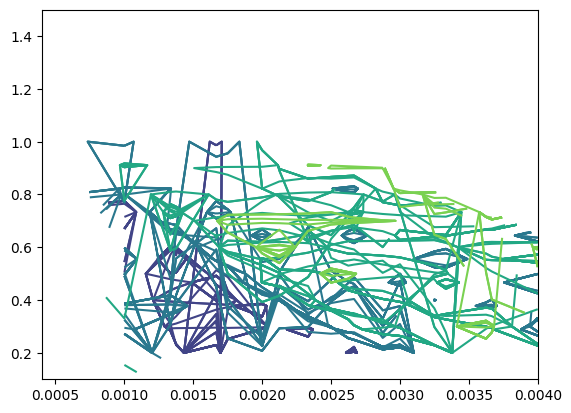

In [44]:
from scipy.interpolate import griddata
xx, yy = np.meshgrid(x, y)
z2 = griddata((x, y), z, (xx, yy), method='linear')
z2 = z2.reshape(xx.shape)
plt.contour(xx, yy, z2, levels=5)

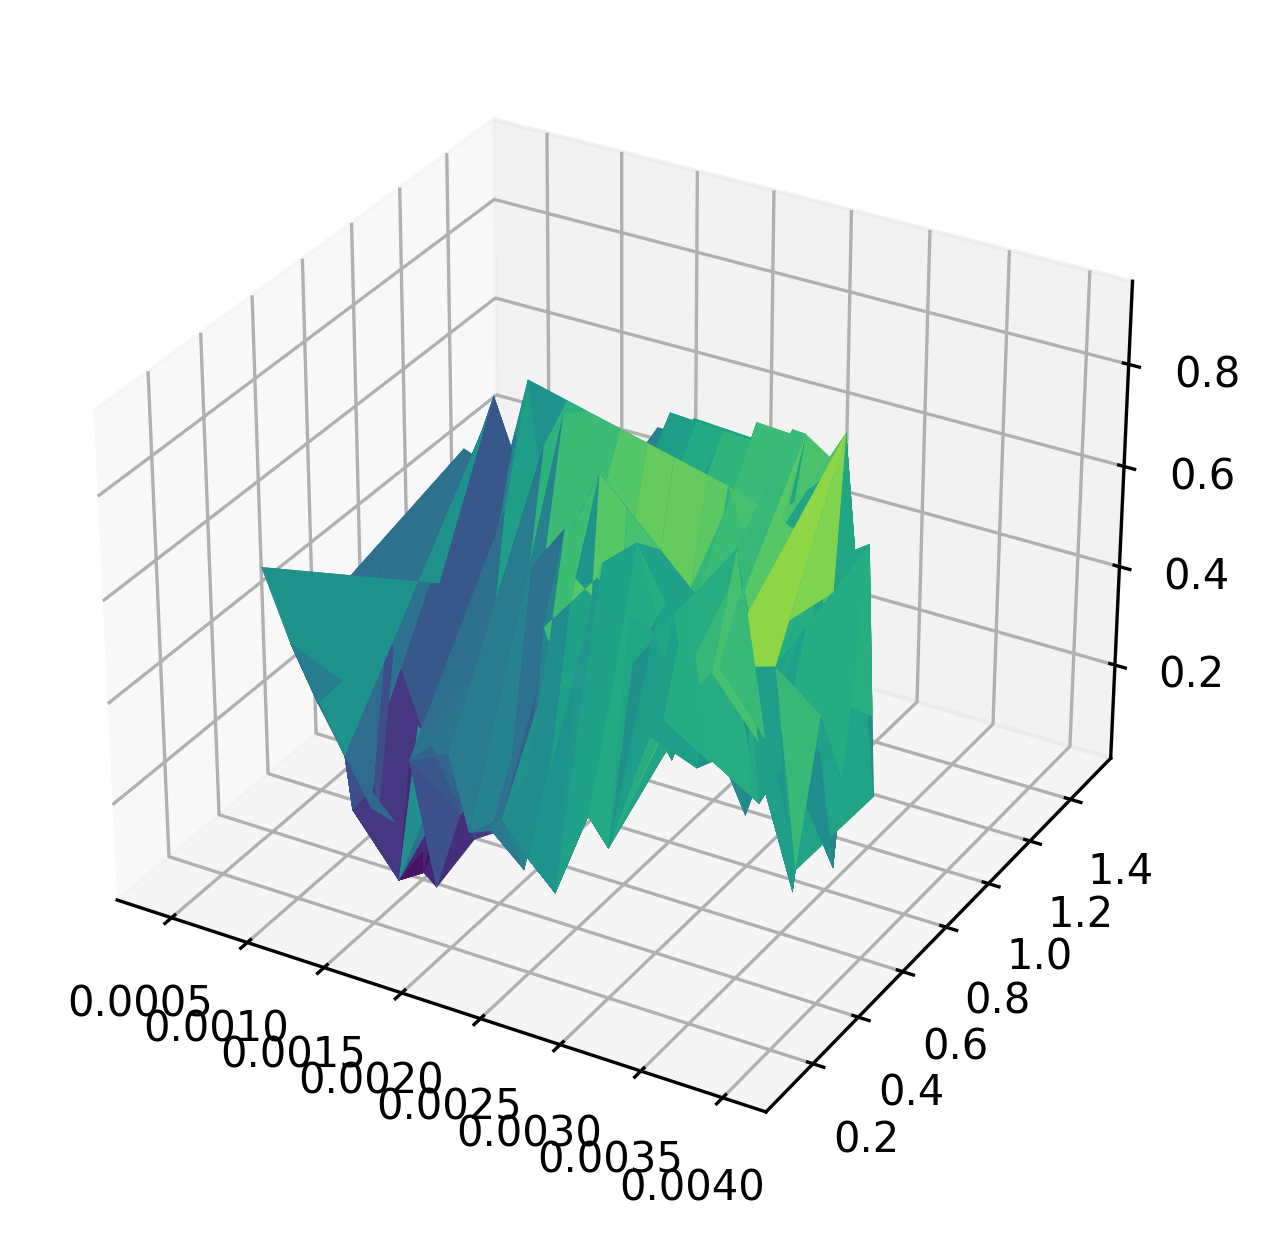

In [45]:
# make a 3d surface of the error
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(figsize=(5, 5), dpi=300, subplot_kw={'projection': '3d'})
ax.plot_surface(xx, yy, z2, cmap='viridis', edgecolor='none')

In [46]:
# plot the average error as a function of NC_K and SIGMA_K. 


In [47]:
X = sol_data[sig_cols].to_numpy()
X = np.column_stack((X, nc_k, sigma_k, tau))
Y = sol_data['error'].to_numpy()

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 958 and the array at index 1 has size 3013

In [ ]:
# split into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# get a nueral network from sklearn
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(10), activation='relu', solver='adam', max_iter=100000)
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=1000, max_depth=10)

NameError: name 'train_test_split' is not defined

In [36]:
# fit
model.fit(X_train, Y_train)

NameError: name 'X_train' is not defined

In [205]:
# parity plot 
pred = model.predict(X_test)
plt.scatter(Y_test, pred, edgecolors='black', linewidth=0.5)

NameError: name 'X_test' is not defined

In [138]:
r2 = r2_score(Y_test, pred)
mae = mean_absolute_error(Y_test, pred)
mse = mean_squared_error(Y_test, pred)
print('R2: {:.2f}'.format(r2))
print('MAE: {:.2f}'.format(mae))
print('MSE: {:.2f}'.format(mse))

R2: 0.67
MAE: 0.11
MSE: 0.03


In [140]:
X_train.shape

(1609, 54)

In [141]:
sol_data

,Unnamed: 0,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,FileHandle,SoluteName,Formula,...,sigma_41,sigma_42,sigma_43,sigma_44,sigma_45,sigma_46,sigma_47,sigma_48,sigma_49,sigma_50
0,0,0.002472,0.448381,0.000635,0.125520,-139.568960,2100,0008noc,n-octane,H18C8,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30,0.002442,0.465850,0.000624,0.121470,-139.573010,2100,0008noc,n-octane,H18C8,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,60,0.002517,0.419506,0.000655,0.132640,-139.561840,2100,0008noc,n-octane,H18C8,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,90,0.002471,0.449172,0.000635,0.125330,-139.569150,2100,0008noc,n-octane,H18C8,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,120,0.002491,0.450552,0.000632,0.124000,-139.570480,2100,0008noc,n-octane,H18C8,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408,102365,0.002719,0.450000,0.000382,-0.275203,-14.502813,2285,0217wat,water,H2O1,...,3.16408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5414,102443,0.002531,0.510000,0.000382,-0.285486,-14.513096,2285,0217wat,water,H2O1,...,3.16408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5418,102495,0.002508,0.457500,0.000382,-0.264178,-14.491788,2285,0217wat,water,H2O1,...,3.16408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5456,103041,0.002500,0.600000,0.000525,-0.312397,-14.540007,2285,0217wat,water,H2O1,...,3.16408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# get every unique sigma profile
sig_unique = sol_data[sig_cols].drop_duplicates()

In [49]:
def evaluate_unique_chems(parameters):
    nc_k = parameters[0]
    sigma_k = parameters[1]
    tau = parameters[2]
    rows, cols = sig_unique.shape
    parameter_array = np.zeros((rows, 3))
    parameter_array[:, 0] = nc_k
    parameter_array[:, 1] = sigma_k
    parameter_array[:, 2] = tau
    predictions = model.predict(np.column_stack((sig_unique, parameter_array)))
    return np.mean(predictions)

In [50]:
# test
evaluate_unique_chems([0.5, 0.5, 0.5])

ValueError: X has 54 features, but RandomForestRegressor is expecting 51 features as input.

In [51]:
n = 5
nc_k_sample = np.linspace(1e-3, 3e-3, n)
sigma_k_sample = np.linspace(0.2, 1, n)
tau_sample = np.ones(n)*0.000525
tau = 0.000525
predictions = []
for nc_k in nc_k_sample:
    for sigma_k in sigma_k_sample:
            predictions.append(evaluate_unique_chems([nc_k, sigma_k, tau]))
predictions

ValueError: X has 54 features, but RandomForestRegressor is expecting 51 features as input.

In [52]:
x = nc_k_sample
y = sigma_k_sample
print(x.shape, y.shape)
xx, yy = np.meshgrid(x, y)
predictions = np.array(predictions).reshape(xx.shape)
# plot a contour plot of the error
plt.contour(xx, yy, predictions, levels=10)
# add a colorbar
plt.colorbar()

(5,) (5,)


ValueError: cannot reshape array of size 0 into shape (5,5)

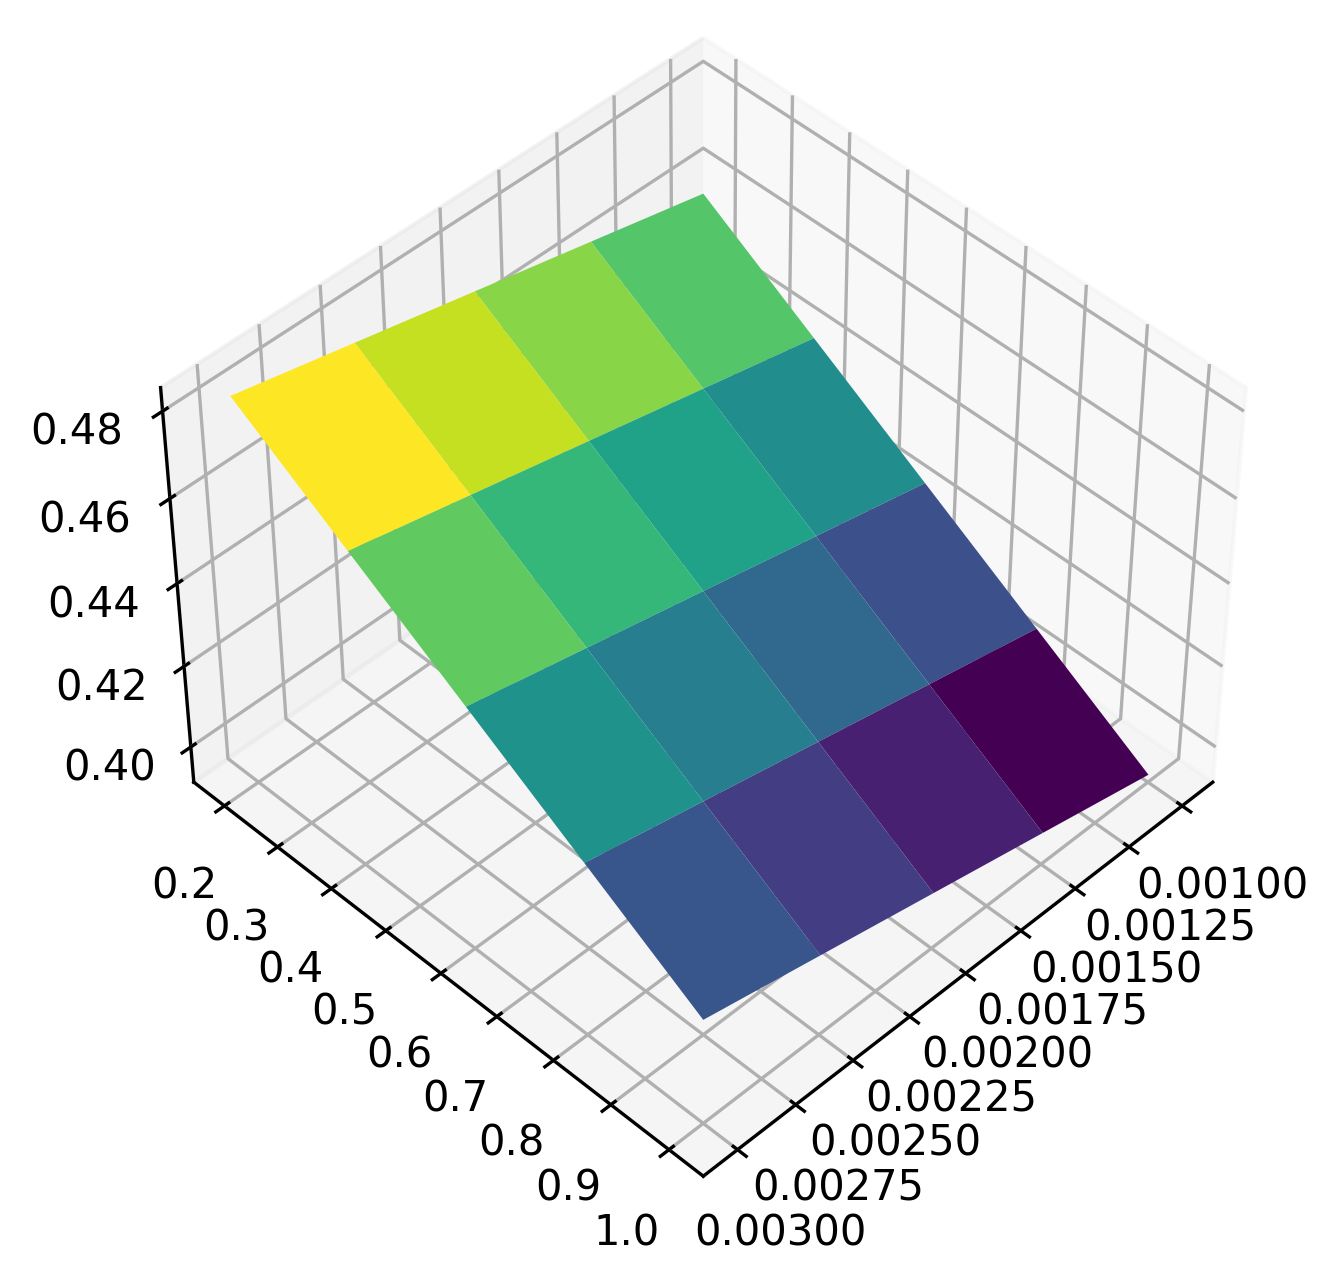

In [194]:
# make a 3d surface plot
fig, ax = plt.subplots(figsize=(5, 5), dpi=300, subplot_kw={'projection': '3d'})
# change the viewing angle to be top down
ax.view_init(45, 45)
ax.plot_surface(xx, yy, predictions, cmap='viridis', edgecolor='none')

In [191]:
# linear regression using sklearn
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, Y_train)


LinearRegression()

In [195]:
X_train.shape

(1609, 54)

In [53]:
# group the dataframe using NC_K, SIGMA_K, and TAU
sol_data = sol_data[sol_data['TAU'] == 0.000525]
grouped_parameters = sol_data.groupby(['NC_K', 'SIGMA_K'])
# get the average error for each group
avg_error = grouped_parameters['error'].mean()

x = grouped_parameters['NC_K']
y = grouped_parameters['SIGMA_K']
z = avg_error
z

NC_K    SIGMA_K 
0.0004  1.500000    0.290092
0.0007  0.800000    0.473203
0.0010  0.100000    0.701192
        0.200000    0.515155
        0.288889    0.454161
                      ...   
0.0040  0.400000    0.569854
        0.466667    0.246115
        0.555556    0.668895
        0.600000    0.812936
        0.644444    0.309511
Name: error, Length: 133, dtype: float64

In [54]:
# lets use the NC_K, SIGMA_K values as the grid points
nc_k = avg_error.index.get_level_values('NC_K').to_numpy()
sigma_k = avg_error.index.get_level_values('SIGMA_K').to_numpy()
error = avg_error.to_numpy()

In [55]:
nc_k.shape, sigma_k.shape, error.shape

((133,), (133,), (133,))

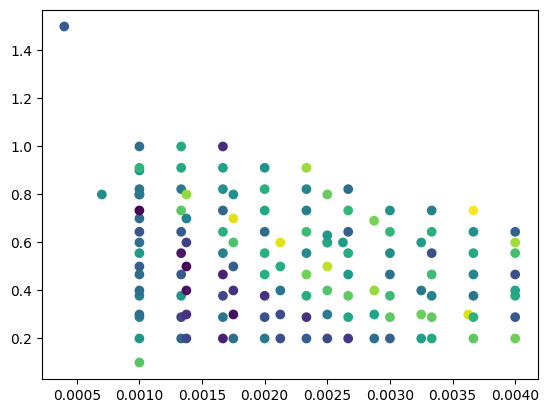

In [56]:
# make a scatter plot and color the points by the error
plt.scatter(nc_k, sigma_k, c=error, cmap='viridis')

In [66]:
# lets make a new sol_data dataframe that only contains the unique NC_K, SIGMA_K with more than 10 data points
# get the NC_K, SIGMA_K, and TAU for each molecule
# list of testing molecules
names = ['n-octane','ethanol','nitromethane','phenol','toluene','1,4-dioxane','acetone','acetic acid','2-butanone']
sol_data = pd.read_csv('../data/VASPsol_Data.csv')
sol_data['error'] = np.abs(sol_data['error'])
sol_data = sol_data[sol_data['Solvent'] == 'water']
sol_data = sol_data[sol_data['TAU'] == 0.000525]
nc_k_low_bound = 2e-3
n_k_high_bound = 3e-3
sigma_k_low_bound = 0
sigma_k_high_bound = 1
print(sol_data.shape)
sol_data = sol_data[(sol_data['NC_K'] >= nc_k_low_bound) & (sol_data['NC_K'] <= n_k_high_bound)]
print(sol_data.shape)
sol_data = sol_data[(sol_data['SIGMA_K'] >= sigma_k_low_bound) & (sol_data['SIGMA_K'] <= sigma_k_high_bound)]



sol_data = sol_data[sol_data['error'].abs() < 10]
sol_data['error'] = sol_data['error'].abs()
sol_data = sol_data[sol_data['SoluteName'].isin(names)]
counts = sol_data.groupby(['NC_K', 'SIGMA_K']).size()
#counts = counts[counts == len(names)]
# get the index of the counts
count_index = counts.index
# get the rows of the sol_data dataframe that match the index
sol_data2 = sol_data[sol_data[['NC_K', 'SIGMA_K']].apply(tuple, axis=1).isin(count_index)]
sol_data2, sol_data2['SoluteName'].unique()

(4412, 67)
(2724, 67)


(      Unnamed: 0 Solvent FileHandle      NC_K  SIGMA_K       TAU  \
 526          526   water    0008noc  0.002500     0.63  0.000525   
 555          555   water    0008noc  0.002625     0.60  0.000525   
 577          577   water    0008noc  0.002500     0.60  0.000525   
 594          594   water    0045eth  0.002500     0.63  0.000525   
 612          612   water    0045eth  0.002625     0.60  0.000525   
 ...          ...     ...        ...       ...      ...       ...   
 8691        8691   water    0036tol  0.002625     0.60  0.000525   
 8714        8714   water    0036tol  0.002500     0.60  0.000525   
 8752        8752   water    0053phe  0.002500     0.63  0.000525   
 8780        8780   water    0053phe  0.002625     0.60  0.000525   
 8794        8794   water    0053phe  0.002500     0.60  0.000525   
 
       Solvation_Energy  Total_Energy   No. SoluteName  ...   OP    S   HS  \
 526           0.063900   -139.630580  2100   n-octane  ...  0.0  0.0  0.0   
 555          

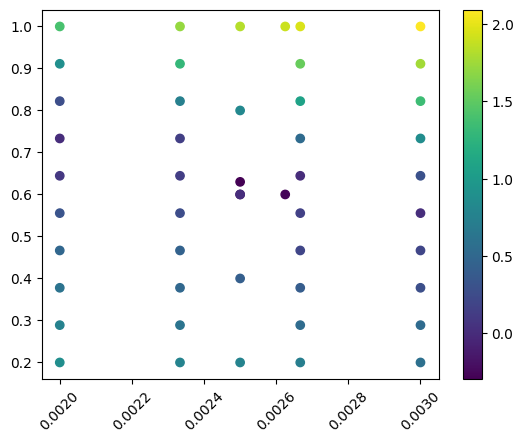

In [75]:
# make the same scatter plot as above with sol_data2

avg_error2 = sol_data2.groupby(['NC_K', 'SIGMA_K'])['error'].mean()
nc_k = avg_error2.index.get_level_values('NC_K').to_numpy()
sigma_k = avg_error2.index.get_level_values('SIGMA_K').to_numpy()
# get the indicies of the dataframe relative to sol_data
error = avg_error2.to_numpy()

# lets make a dataframe with this information
plot_df = pd.DataFrame({'NC_K': nc_k, 'SIGMA_K': sigma_k, 'error': error})

plt.scatter(nc_k, sigma_k, c=np.log(error), cmap='viridis')
# rotate the xticks by 45 degrees
plt.xticks(rotation=45)
plt.colorbar()

        NC_K   SIGMA_K     error
0   0.002000  0.200000  2.408032
1   0.002000  0.288889  2.114661
2   0.002000  0.377778  1.836767
3   0.002000  0.466667  1.627632
4   0.002000  0.555556  1.385216
5   0.002000  0.644444  1.092235
6   0.002000  0.733333  1.009087
7   0.002000  0.822222  1.307892
8   0.002000  0.911111  2.418600
9   0.002000  1.000000  4.049166
10  0.002333  0.200000  2.159309
11  0.002333  0.288889  1.855518
12  0.002333  0.377778  1.654609
13  0.002333  0.466667  1.556306
14  0.002333  0.555556  1.290978
15  0.002333  0.644444  1.150342
16  0.002333  0.733333  1.156575
17  0.002333  0.822222  2.083153
18  0.002333  0.911111  3.639558
19  0.002333  1.000000  5.537146
29  0.002667  0.200000  2.047463
30  0.002667  0.288889  1.704775
31  0.002667  0.377778  1.483965
32  0.002667  0.466667  1.223555
33  0.002667  0.555556  1.182126
34  0.002667  0.644444  1.008157
35  0.002667  0.733333  1.689347
36  0.002667  0.822222  2.944648
37  0.002667  0.911111  4.661422
38  0.0026

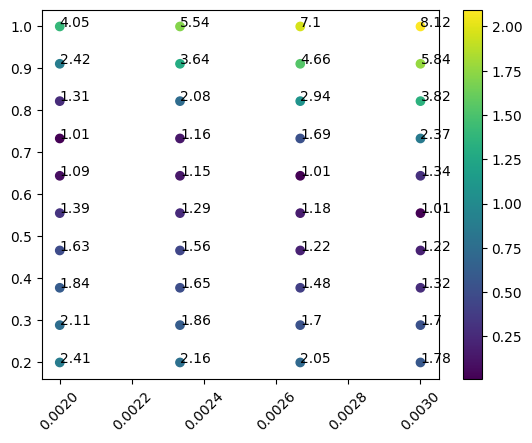

In [76]:
# remove all values of NC_K at 0.0025
sol_data3 = plot_df[(plot_df['NC_K'] != 0.0025) & (plot_df['NC_K'] != 0.002625)]
print(sol_data3)
#sol_data3 = pd.concat([sol_data3, plot_df[(plot_df['NC_K'] == 2.5e-3) & (plot_df['SIGMA_K'] == 0.6)]])
avg_error2 = sol_data3.groupby(['NC_K', 'SIGMA_K'])['error'].mean()
nc_k = avg_error2.index.get_level_values('NC_K').to_numpy()
sigma_k = avg_error2.index.get_level_values('SIGMA_K').to_numpy()
# get the indicies of the dataframe relative to sol_data
error = avg_error2.to_numpy()


# lets make a dataframe with this information
plot_df = pd.DataFrame({'NC_K': nc_k, 'SIGMA_K': sigma_k, 'error': error})

plt.scatter(nc_k, sigma_k, c=np.log(error), cmap='viridis')
# rotate the xticks by 45 degrees
plt.xticks(rotation=45)
plt.colorbar()
print(plot_df['NC_K'].unique())
# put a label on each point with the error

for i in range(len(nc_k)):
    plt.annotate(np.round(error[i], 2), (nc_k[i], sigma_k[i]))

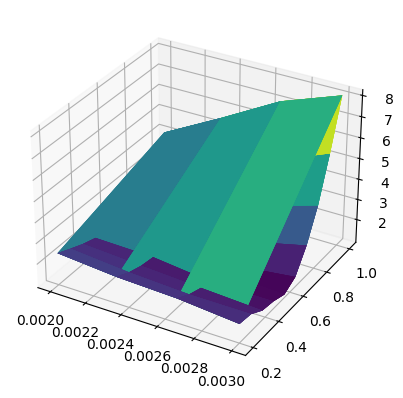

In [77]:
# make a surface plot
xx, yy = np.meshgrid(nc_k, sigma_k)
z = griddata((nc_k, sigma_k), plot_df['error'], (xx, yy), method='cubic')
z.reshape(xx.shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(xx, yy, z, cmap='viridis')


C:\Users\efons\AppData\Local\Temp\ipykernel_25080\486388329.py:12: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = interp2d(x, y, error, kind='cubic')
C:\Users\efons\AppData\Local\Temp\ipykernel_25080\486388329.py:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2

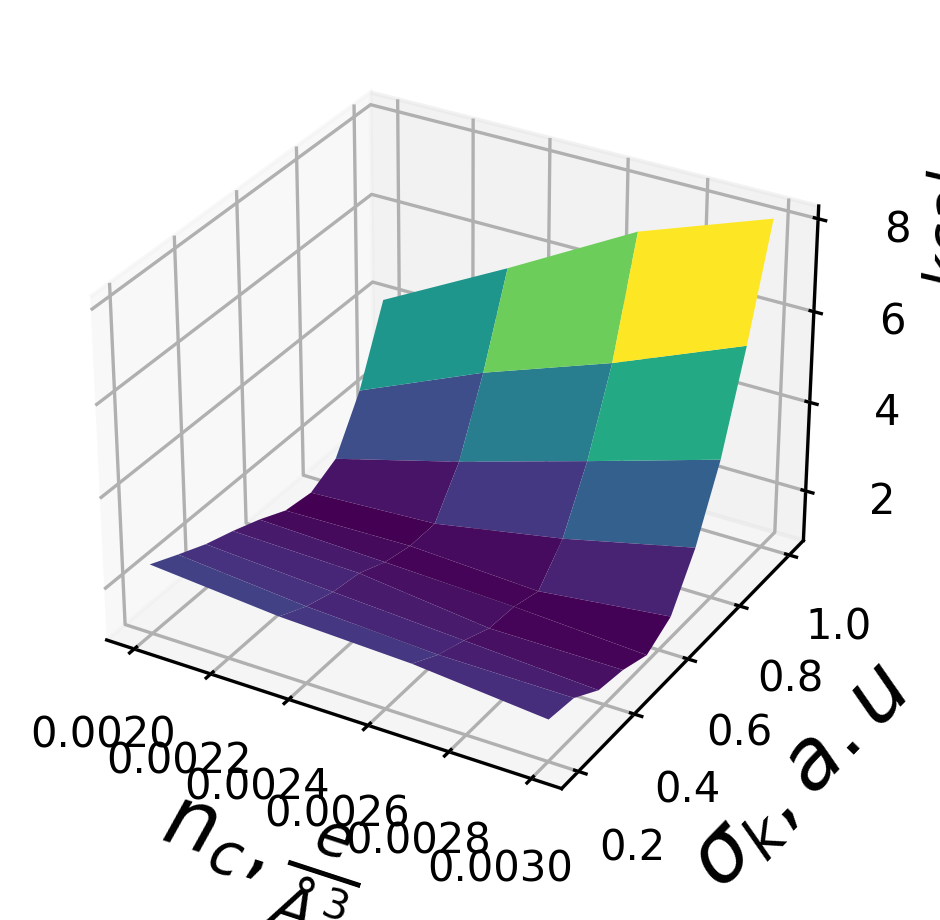

In [78]:
# make an interpolator for this surface. This will be used to find the minimum error
x = plot_df['NC_K'].unique()
y = plot_df['SIGMA_K'].unique()

# import the scipy interpolate module to make a 2D interpolator

from scipy.interpolate import griddata, interp2d, RectBivariateSpline

xx, yy = np.meshgrid(x, y)

# make a 2D interpolator using a lambda function to make a function that takes in x and y and returns the error
f = interp2d(x, y, error, kind='cubic')
# make a surface plot using hte interpolator
z = np.array([f(x, y) for x, y in zip(np.ravel(xx), np.ravel(yy))])
z = z.reshape(xx.shape)
fig, ax = plt.subplots(figsize=(10, 10), dpi=300, subplot_kw={"projection": "3d"})
ax.plot_surface(xx, yy, z, cmap='viridis')
# label all the axes with beautiful latex formatting worthy of a conference presentation
plt.xlabel(r'$n_c, \frac{e}{\AA^3}$', fontsize=20)
plt.ylabel(r'$\sigma_k, a.u$', fontsize=20)
# label the z axis with the error
ax.set_zlabel(r'$error, \frac{kcal}{mol}$', fontsize=20)
plt.gcf().set_size_inches(3, 3)
plt.tight_layout()
# make the size of the plot a little smaller so that the labels are not cut off


(4,) (10,) [2.40803241 2.11466137 1.83676675 1.62763231 1.38521571 1.09223512
 1.00908696 1.30789176 2.41860019 4.0491662  2.15930882 1.85551782
 1.65460922 1.55630591 1.29097755 1.15034161 1.15657533 2.08315296
 3.63955759 5.53714564 2.04746301 1.7047746  1.48396522 1.22355523
 1.18212597 1.00815672 1.68934745 2.9446482  4.66142238 7.09818246
 1.78050364 1.69711411 1.3184636  1.22173537 1.01237795 1.34407949
 2.36739052 3.82325397 5.83980485 8.12169237]


C:\Users\efons\AppData\Local\Temp\ipykernel_25080\2726379824.py:20: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = interp2d(x, y, error, kind='cubic')
C:\Users\efons\AppData\Local\Temp\ipykernel_25080\2726379824.py:22: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered

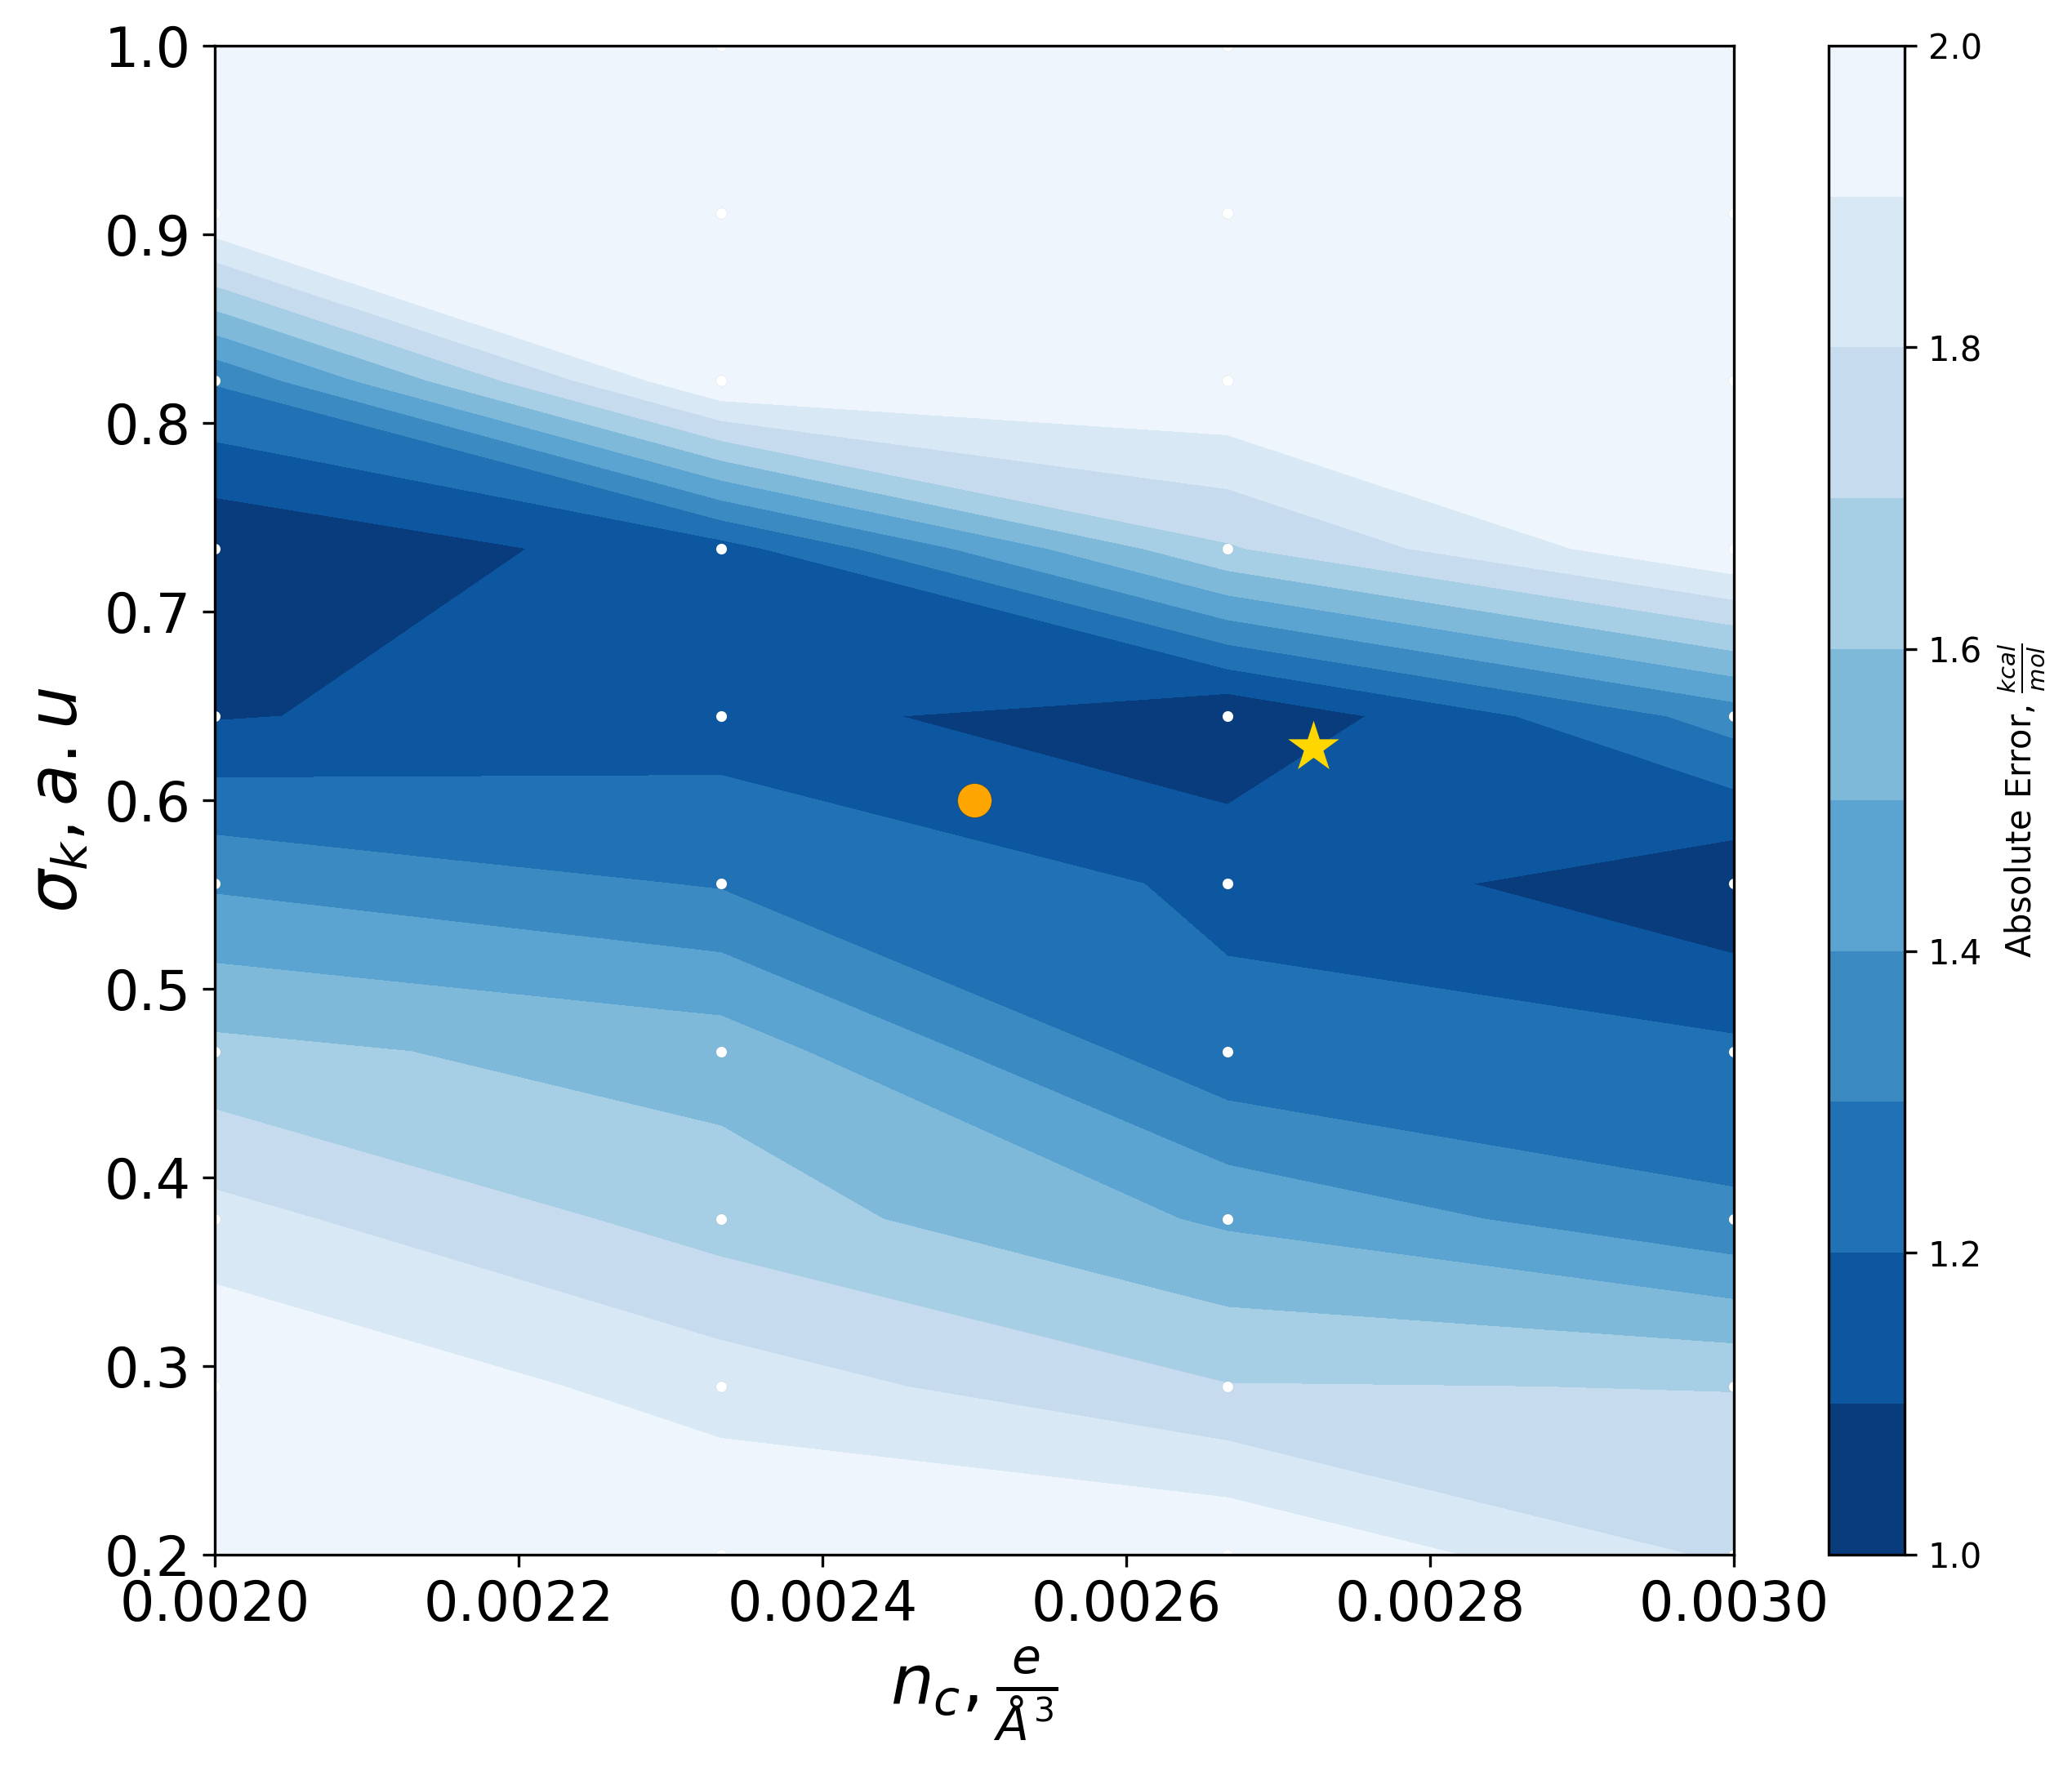

In [88]:
# make an interpolator for this surface. This will be used to find the minimum error
x = plot_df['NC_K'].unique()
y = plot_df['SIGMA_K'].unique()
print(x.shape, y.shape, error)
# lets bound x and y 
#x_bounds = [2e-3, 3e-3]
#y_bounds = [0.5, 0.7]

#idx_to_keep = (x > x_bounds[0]) & (x < x_bounds[1]) & (y > y_bounds[0]) & (y < y_bounds[1])
#x = x[idx_to_keep]
#y = y[idx_to_keep]

# import the scipy interpolate module to make a 2D interpolator

from scipy.interpolate import griddata, interp2d, RectBivariateSpline

xx, yy = np.meshgrid(x, y)

# make a 2D interpolator using a lambda function to make a function that takes in x and y and returns the error
f = interp2d(x, y, error, kind='cubic')
# make a surface plot using hte interpolator
z = np.array([f(x, y) for x, y in zip(np.ravel(xx), np.ravel(yy))])
z = z.reshape(xx.shape)

# make a 2D contourf plot. beautiful bold letters with the university of florida colors as the theme
# make the change in the colorbar logarithmic
from matplotlib.colors import LogNorm
# invert the blues colors so that the lowest error is the darkest blue
locs = np.where(z > 2)
z[locs] = 2
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
plt.contourf(xx, yy, z, levels=10, cmap='Blues_r')
plt.colorbar(label=r'Absolute Error, $\frac{kcal}{mol}$') #norm=LogNorm(vmin=1e-3, vmax=1e1))

plt.xlabel(r'$n_c, \frac{e}{\AA^3}$', fontsize=20)
plt.ylabel(r'$\sigma_k, a.u$', fontsize=20)
# make tick marks bigger
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
#ax.set_zlabel(r'$error, \frac{kcal}{mol}$', fontsize=20)
# put a small pale blue dot with a thin black outline at each grid point
for i in range(len(x)):
    for j in range(len(y)):
        plt.scatter(x[i], y[j], c='w', edgecolors='k', s=10, linewidths=0.01)

# use a solver to find the minimum of the interpolator

from scipy.optimize import minimize

g = lambda x: f(x[0], x[1])
opt = minimize(g, [0.0025, 0.6], method='Nelder-Mead')
# put a gold star at the minimum
x_min, y_min = opt.x
plt.scatter(x_min, y_min, c='gold', s=250, marker='*', edgecolors='k', linewidths=0.01)
# put an orange dot with a thin black outline at the default values
x_default = 0.0025
y_default = 0.6
plt.scatter(x_default, y_default, c='orange', edgecolors='k', s=100, linewidths=0.05)


C:\Users\efons\AppData\Local\Temp\ipykernel_4344\838252091.py:20: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  g = lambda x: f(x[0], x[1])


QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull d Qbb Qz Qc Q12 Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 891886103  delaunay  Qbbound-last  Qz-infinity-point  Qcoplanar-keep
  Q12-allow-wide  Qtriangulate  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width 0.15  Error-roundoff 9.7e-16  _one-merge 6.8e-15
  Visible-distance 1.9e-15  U-max-coplanar 1.9e-15  Width-outside 3.9e-15
  _wide-facet 1.2e-14  _maxoutside 7.8e-15

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p8(v4): 0.0029  0.68  0.49
- p10(v3): 0.0027  0.63   0.7
- p9(v2): 0.003   0.7  0.55
- p0(v1): 0.0025  0.55     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 9.7e-16.  The center point, facets and distances
to the center point are as follows:

center point 0.002799   0.6396   0.4354

facet p10 p9 p0 distance= 1.7e-19
facet p8 p9 p0 distance= -3.8e-18
facet p8 p10 p0 distance= -4.7e-19
facet p8 p10 p9 distance= -1.2e-18

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:    0.0025     0.003  difference= 0.0005
  1:      0.55       0.7  difference= 0.15
  2:         0       0.7  difference=  0.7

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 9.7e-16.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


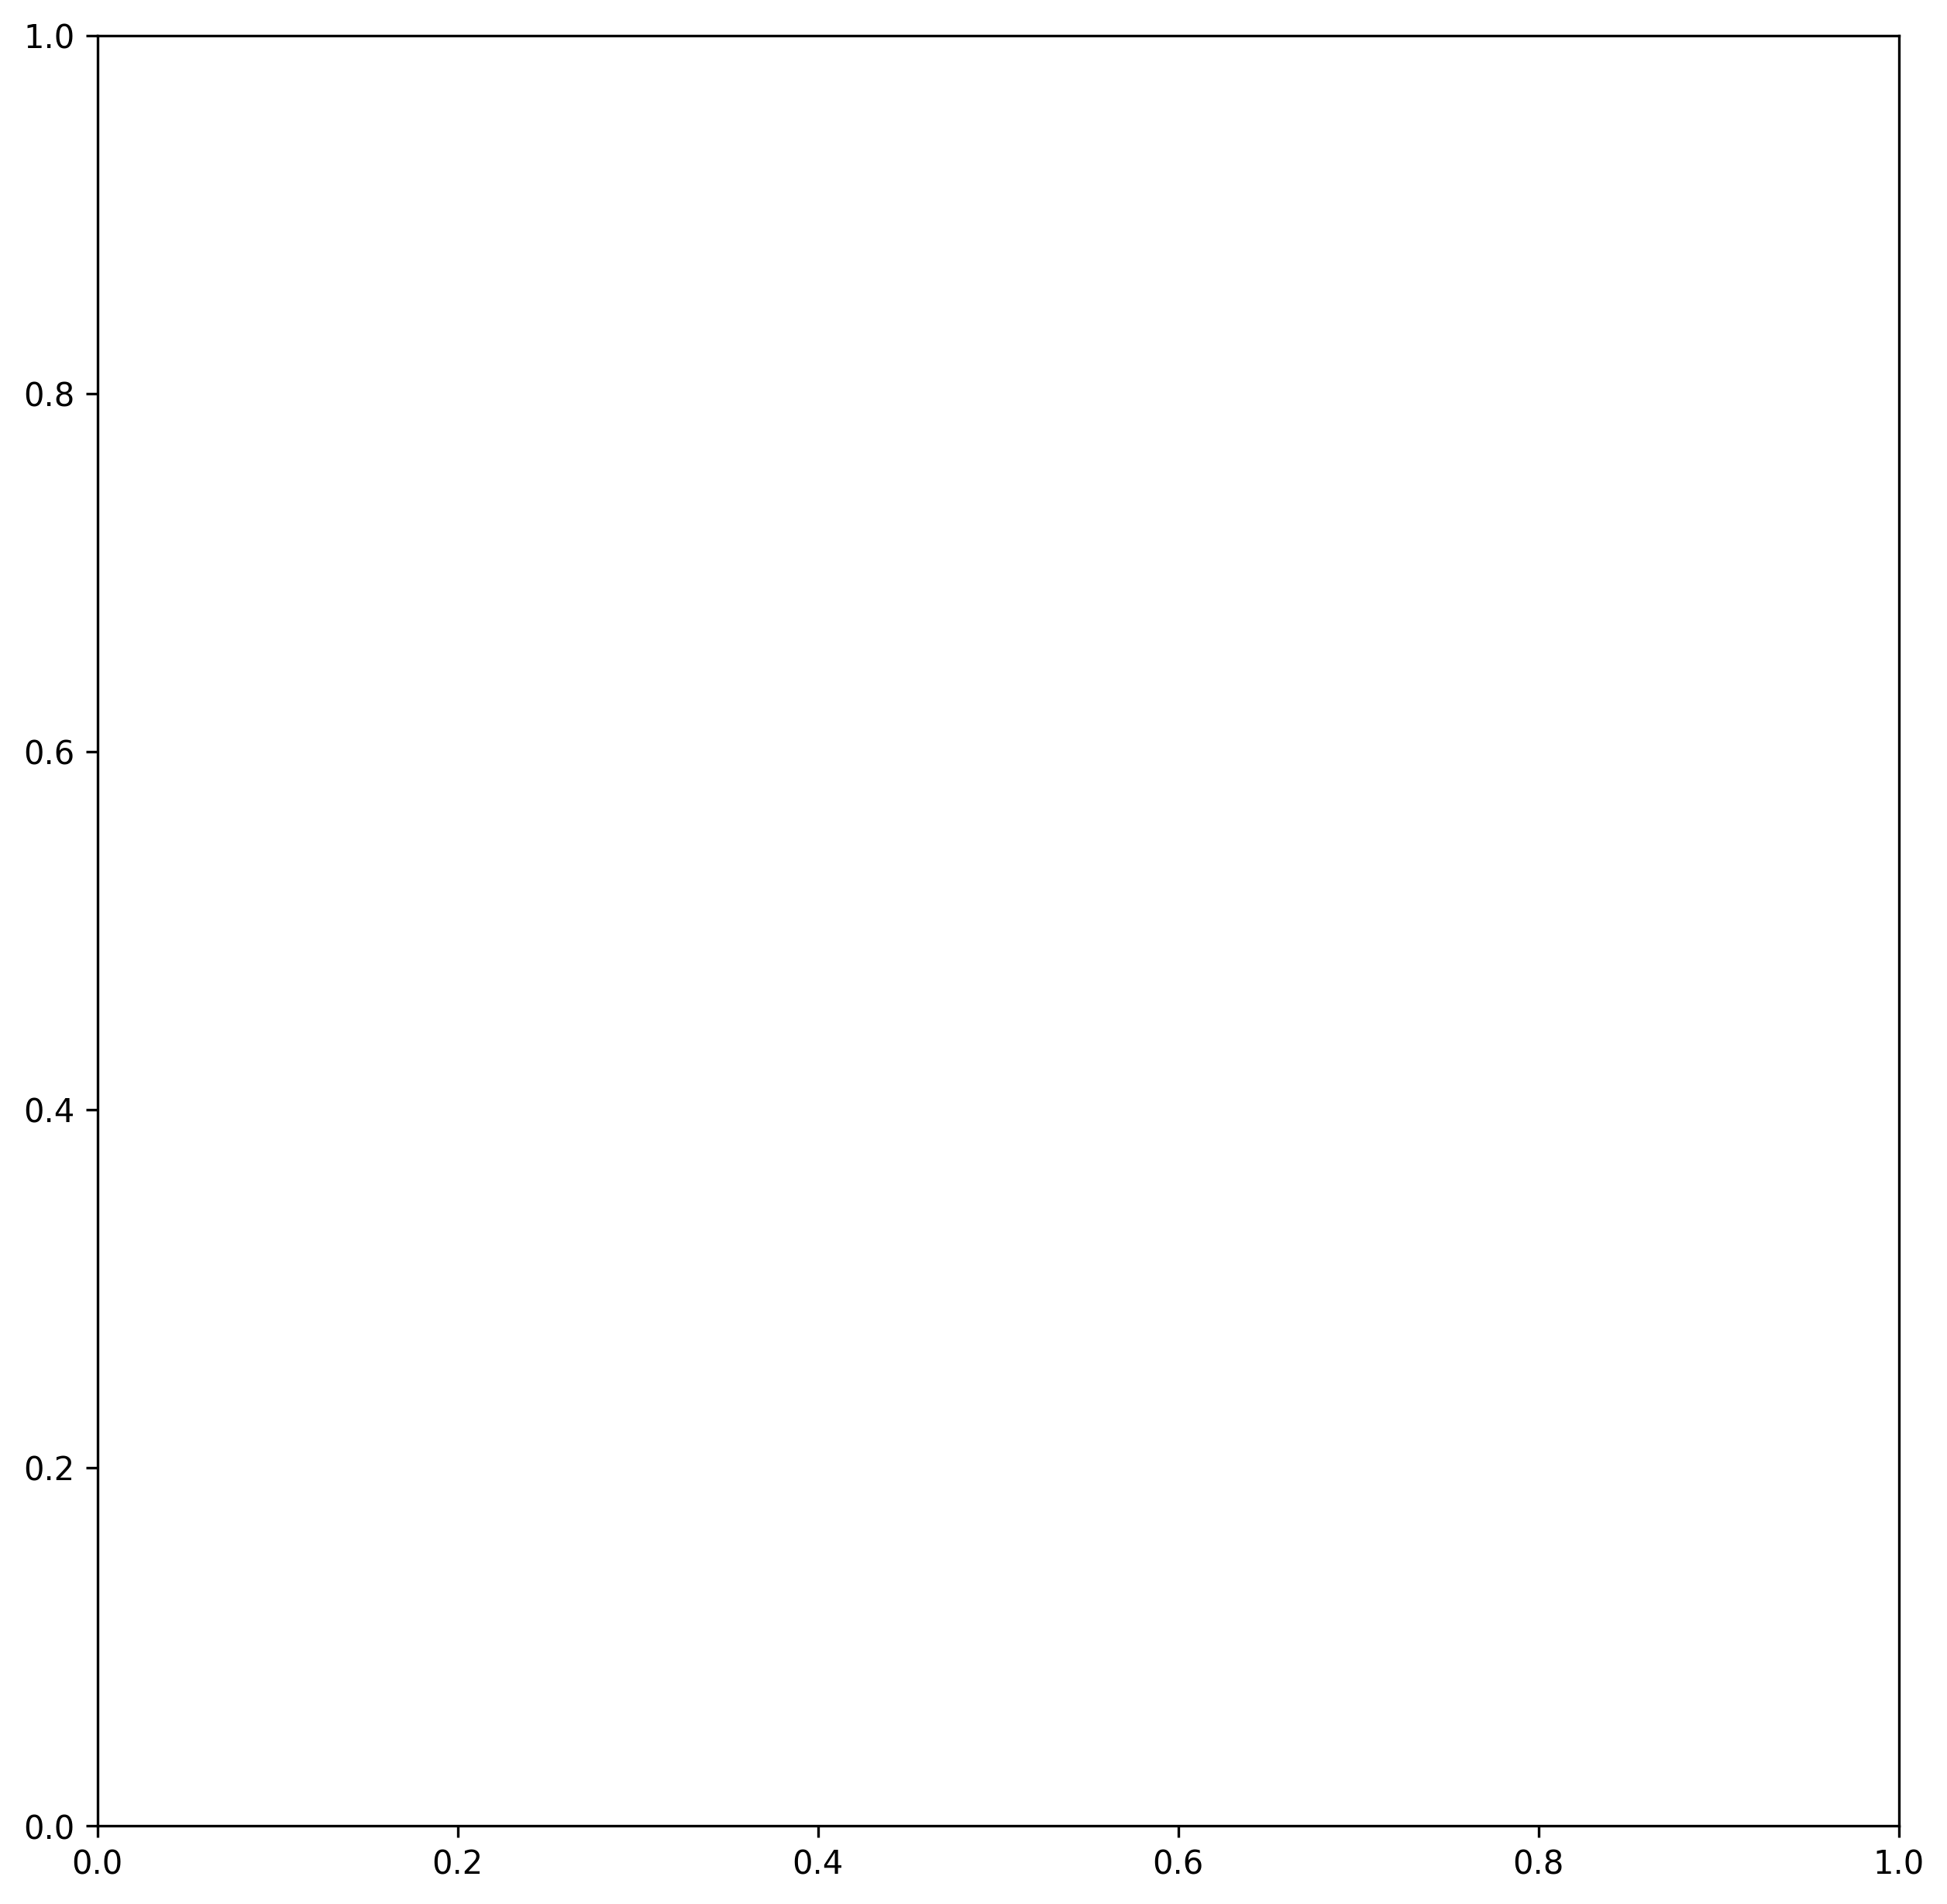

In [ ]:

# lets make an identical plot but using the range x_range, and y_range
x_range = np.linspace(0.0025, 0.003, 10)
y_range = np.linspace(0.55, 0.7, 10)
z_range = np.array([g([x, y]) for x, y in zip(x_range, y_range)])
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
xx_range, yy_range = np.meshgrid(x_range, y_range)
zz_range = griddata((x_range, y_range), z_range, (xx_range, yy_range), method='linear')
plt.hist(zz_range)

In [186]:
opt

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.9921563941087774
             x: [ 2.723e-03  6.282e-01]
           nit: 24
          nfev: 48
 final_simplex: (array([[ 2.723e-03,  6.282e-01],
                       [ 2.723e-03,  6.283e-01],
                       [ 2.723e-03,  6.282e-01]]), array([ 9.922e-01,  9.922e-01,  9.922e-01]))

[1.00815672 2.78654063 4.56492454 6.34330846 8.12169237]


C:\Users\efons\AppData\Local\Temp\ipykernel_4344\3909939434.py:9: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = interp2d(nc_k, sigma_k, error, kind='linear')
c:\users\efons\anaconda3\envs\venv\lib\site-packages\scipy-1.10.0rc1-py3.10-win-amd64.egg\scipy\interpolate\_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=7,11 m=40 fp=0.041968 s=0.000000
  wa

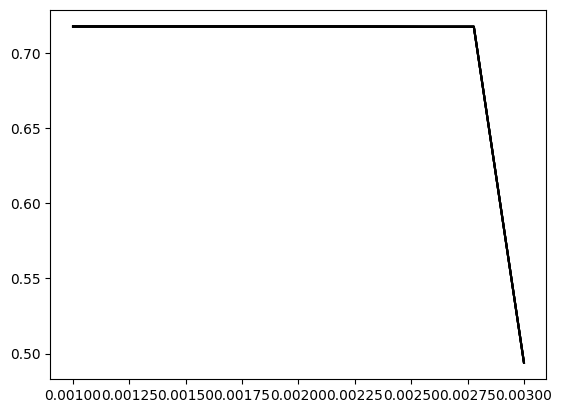

In [ ]:
# lets use the function from the previous notebook to make a contour plot
# plot a bunch of lines with different colors of NC_K, SIGMA_K. find the iso values of the error given a staring point and move NC_K optimizing SIGMA_K along the path to maintain the same error value
from scipy import optimize
from scipy.interpolate import interp2d
nc_k_array = np.linspace(1e-3, 3e-3, 10)
selected_error = np.linspace(z.min(), z.max(), 5)
print(selected_error)
sig_matrix = []
f = interp2d(nc_k, sigma_k, error, kind='linear')
#for n in nc_k_array:
#    sigma_array = []
#    for e in selected_error:
#        print('error = ', e)
  #      g = lambda x: f(n, x) - e
 #       # find the root of the function
 #       optim = optimize.minimize(g, 1, method='Nelder-Mead')
#        sigma_array.append(optim.x)
#        del g, optim
#    sigma_array = np.array(sigma_array).reshape(1, -1)
#    plt.plot(nc_k_array, sigma_array, 'k')
    
    
# the above code is not working. lets try a different approach. lets loop through the error first and plot each NC_K, SIGMA_K pair for each error value

sig_matrix = []
for e in selected_error:
    sigma_array = []
    for n in nc_k_array:
        g = lambda x: f(n, x) - e
        # find the root of the function
        optim = optimize.minimize(g, 1, method='Nelder-Mead')
        sigma_array.append(optim.x)
        del g, optim
    sigma_array = np.array(sigma_array).reshape(-1)
    sig_matrix.append(sigma_array)
    plt.plot(nc_k_array, sigma_array, 'k')

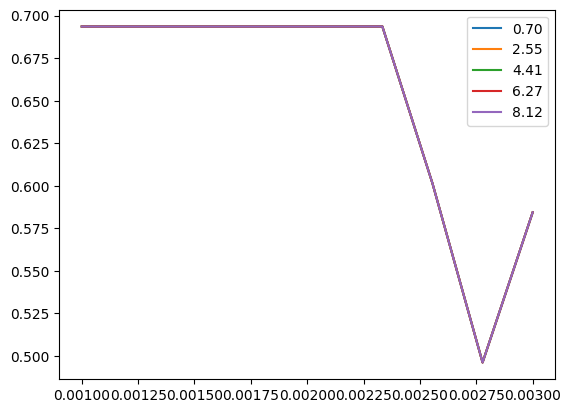

In [ ]:
# plot the contour lines
for i in range(5):
    plt.plot(nc_k_array, sig_matrix[:, i], label=f'{selected_error[i]:.2f}')
plt.legend()

In [ ]:
# makes make a interpolation function
from scipy.interpolate import interp2d
f = interp2d(nc_k, sigma_k, error)
f2 = lambda x: f(x[0], x[1])
# get a optimizer from scipy
from scipy.optimize import minimize
optim = minimize(f2, x0=[1e-3, 0.5], method='Nelder-Mead')
# get the optimized parameters
nc_k_opt, sigma_k_opt = optim.x
# print the optimized parameters
print('nc_k_opt =', nc_k_opt)
print('sigma_k_opt =', sigma_k_opt)

nc_k_opt = 0.0008063964843749991
sigma_k_opt = 0.6936035156249991


C:\Users\efons\AppData\Local\Temp\ipykernel_18072\880974030.py:3: DeprecationWarning:

`interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`


c:\users\efons\anaconda3\envs\venv\lib\site-packages\scipy-1.10.0rc1-py3.10-win-amd64.egg\scipy\interpolate\_fitpack_impl.py:975: RuntimeWarning:

No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=9,10 m=49 fp=0.086182 s=0.000000

C:\Users\efons\AppData\Local\Temp\ipykernel_18072\88

min error = 0.7415283000000169
max error = 8.121692372000046
mean error = 2.389597203754618


C:\Users\efons\AppData\Local\Temp\ipykernel_18072\2521412599.py:2: UserWarning:

The following kwargs were not used by contour: 'offset'



(array([0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 ]),
 [Text(0.0005, 0, '0.0005'),
  Text(0.001, 0, '0.0010'),
  Text(0.0015, 0, '0.0015'),
  Text(0.002, 0, '0.0020'),
  Text(0.0025, 0, '0.0025'),
  Text(0.003, 0, '0.0030')])

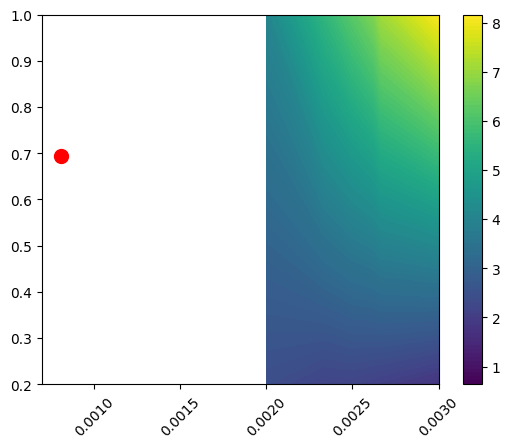

In [ ]:
# replot the contour plot and place a big red star at the optimized parameters
plt.contourf(xx, yy, z, offset=-1, cmap='viridis', levels=100)
# add a colorbar with limits from 0 to 10
plt.colorbar(ticks=np.linspace(0, 10, 11))
plt.scatter(nc_k_opt, sigma_k_opt, c='r', s=100)
# print min max and mean error
print('min error =', error.min())
print('max error =', error.max())
print('mean error =', error.mean())
# make the color bar start at zero
plt.clim(0.5, 10)
# rotate the xticks by 45 degrees
plt.xticks(rotation=45)

In [120]:
f(1e-3, 0.5)

C:\Users\efons\AppData\Local\Temp\ipykernel_18072\1032360589.py:1: DeprecationWarning:

        `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
        For scattered data, prefer `LinearNDInterpolator` or
        `CloughTocher2DInterpolator`.

        For more details see
        `https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`




array([1.53907827])

In [ ]:
# lets make a 3d plot of the error with plotly. put the SoluteName in the hover text
import plotly.express as px
sol_data['error'] = sol_data['error'].abs()
group2 = sol_data2.groupby(['NC_K', 'SIGMA_K','SoluteName'])['error'].mean()
new_df = pd.DataFrame({'NC_K': group2.index.get_level_values('NC_K').to_numpy(), 'SIGMA_K': group2.index.get_level_values('SIGMA_K').to_numpy(), 'SoluteName': group2.index.get_level_values('SoluteName').to_numpy(), 'error': group2.to_numpy()})
px.scatter_3d(new_df, x='NC_K', y='SIGMA_K', z='error', color='error', hover_name='SoluteName', color_continuous_scale='viridis')

In [40]:
px.scatter_3d(plot_df, x='NC_K', y='SIGMA_K', z='error', color='error', color_continuous_scale='viridis')

In [54]:
avg_error2.shape

(44,)

In [4]:
sol_data = pd.read_csv('VASPsol_Data.csv')
sol_data

,Unnamed: 0,Solvent,FileHandle,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,SoluteName,...,OP,S,HS,OS,SP,SS,TotalArea,error,error_ev,error_frac
0,0,water,0157flu,0.001000,0.200000,0.000670,0.073867,-76.193434,2240,fluorobenzene,...,0.0,0.0,0.0,0.0,0.0,0.0,149.511,-2.483373,-0.107692,3.183812
1,1,water,0157flu,0.002000,0.866667,0.000010,-0.200151,-76.467452,2240,fluorobenzene,...,0.0,0.0,0.0,0.0,0.0,0.0,149.511,3.835482,0.166326,-4.917285
2,2,water,0157flu,0.001000,1.200000,0.001000,-0.042744,-76.310045,2240,fluorobenzene,...,0.0,0.0,0.0,0.0,0.0,0.0,149.511,0.205677,0.008919,-0.263688
3,3,water,0157flu,0.001000,0.200000,0.001000,0.152467,-76.114834,2240,fluorobenzene,...,0.0,0.0,0.0,0.0,0.0,0.0,149.511,-4.295889,-0.186292,5.507550
4,4,water,0157flu,0.003000,0.533333,0.000340,-0.097007,-76.364308,2240,fluorobenzene,...,0.0,0.0,0.0,0.0,0.0,0.0,149.511,1.456981,0.063182,-1.867925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8799,8799,water,0053phe,0.002626,0.638958,0.000483,-0.287089,-82.972285,2142,phenol,...,0.0,0.0,0.0,0.0,0.0,0.0,153.746,0.000272,0.000012,-0.000041
8800,8800,water,0053phe,0.002626,0.639090,0.000483,-0.287114,-82.972310,2142,phenol,...,0.0,0.0,0.0,0.0,0.0,0.0,153.746,0.000849,0.000037,-0.000128
8801,8801,water,0053phe,0.002649,0.632227,0.000485,-0.285222,-82.970418,2142,phenol,...,0.0,0.0,0.0,0.0,0.0,0.0,153.746,-0.042781,-0.001855,0.006462
8802,8802,water,0053phe,0.002626,0.639287,0.000483,-0.287213,-82.972409,2142,phenol,...,0.0,0.0,0.0,0.0,0.0,0.0,153.746,0.003132,0.000136,-0.000473


In [5]:
sol_data2

NameError: name 'sol_data2' is not defined

In [6]:
# there is a grid of sigma values. find their groups
sigma_groups = sol_data.groupby('SIGMA_K')
# look at the unique values of sigma 
sigma_groups['SIGMA_K'].unique()

SIGMA_K
0.001500                [0.0015]
0.003500                [0.0035]
0.004500                [0.0045]
0.100000                   [0.1]
0.200000                   [0.2]
                    ...         
0.911111    [0.9111111111111112]
0.969400                [0.9694]
1.000000                   [1.0]
1.200000                   [1.2]
1.500000                   [1.5]
Name: SIGMA_K, Length: 429, dtype: object

In [11]:
# get all values of sigma in this list
sig_list = [0.2, 0.4, 0.6, 0.8, 1.0]
nc_list = np.array([0.0025    , 0.00233333, 0.003     , 0.002     , 0.00266667])
# get all data in sol_data that has any of these values of sigma and nc_k
grid_df = sol_data[sol_data['SIGMA_K'].isin(sig_list) & sol_data['NC_K'].isin(nc_list)]
grid_df

,Unnamed: 0,Solvent,FileHandle,NC_K,SIGMA_K,TAU,Solvation_Energy,Total_Energy,No.,SoluteName,...,OP,S,HS,OS,SP,SS,TotalArea,error,error_ev,error_frac
9,9,water,0157flu,0.0020,0.2,0.000670,0.034941,-76.232360,2240,fluorobenzene,...,0.0,0.0,0.0,0.0,0.0,0.0,149.511,-1.585739,-0.068766,2.032999
12,12,water,0157flu,0.0030,0.2,0.001000,0.069058,-76.198243,2240,fluorobenzene,...,0.0,0.0,0.0,0.0,0.0,0.0,149.511,-2.372477,-0.102883,3.041638
14,14,water,0157flu,0.0030,0.2,0.000010,-0.092780,-76.360081,2240,fluorobenzene,...,0.0,0.0,0.0,0.0,0.0,0.0,149.511,1.359507,0.058955,-1.742957
27,27,water,0157flu,0.0020,0.2,0.001000,0.102095,-76.165206,2240,fluorobenzene,...,0.0,0.0,0.0,0.0,0.0,0.0,149.511,-3.134311,-0.135920,4.018347
32,32,water,0157flu,0.0020,0.2,0.000010,-0.075275,-76.342576,2240,fluorobenzene,...,0.0,0.0,0.0,0.0,0.0,0.0,149.511,0.955841,0.041450,-1.225438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8717,8717,water,0036tol,0.0025,0.6,0.000551,-0.039489,-92.698863,2126,toluene,...,0.0,0.0,0.0,0.0,0.0,0.0,166.450,0.020616,0.000894,-0.023164
8731,8731,water,0044met,0.0025,0.6,0.000525,-0.194267,-30.399371,2133,methanol,...,0.0,0.0,0.0,0.0,0.0,0.0,84.309,-0.630203,-0.027329,0.123327
8732,8732,water,0044met,0.0025,0.6,0.000551,-0.192224,-30.397328,2133,methanol,...,0.0,0.0,0.0,0.0,0.0,0.0,84.309,-0.677315,-0.029372,0.132547
8794,8794,water,0053phe,0.0025,0.6,0.000525,-0.248040,-82.933236,2142,phenol,...,0.0,0.0,0.0,0.0,0.0,0.0,153.746,-0.900198,-0.039037,0.135982


In [13]:
grid_df.columns

Index(['Unnamed: 0', 'Solvent', 'FileHandle', 'NC_K', 'SIGMA_K', 'TAU',
       'Solvation_Energy', 'Total_Energy', 'No.', 'SoluteName', 'Formula',
       'Subset', 'Charge', 'Level1', 'Level2', 'Level3', 'DeltaGsolv', 'type',
       'eps', 'n', 'alpha', 'beta', 'gamma', 'phi**2', 'psi**2', 'beta**2',
       'H', 'C', 'HC', 'CC', 'CC2', 'N', 'HN', 'HN2', 'CN', 'NC', 'NC2', 'NC3',
       'O', 'HO', 'HO2', 'OC', 'CO2', 'ON', 'OO', 'F', 'Cl', 'Br', 'I', 'FC',
       'ClC', 'BrC', 'IC', 'Si', 'OSi', 'P', 'HP', 'OP', 'S', 'HS', 'OS', 'SP',
       'SS', 'TotalArea', 'error', 'error_ev', 'error_frac'],
      dtype='object')

In [9]:
import numpy as np

In [90]:
(1.17-1.10)/(1.17)

0.05982905982905969